# Fig6 & Fig7, Linguistic toxicity-error patterns

In [1]:
import requests
import json
import hashlib
import base64
import hmac
import datetime
import uuid
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')
METHOD_GET = 'GET'
METHOD_POST = 'POST'

# accessKey
AK = ''
# securityKey
SK = ''
app_key = ''


def sha256(content):
    x = hashlib.sha256()
    x.update(content.encode())
    return x.hexdigest().upper()


def hmac_sha256(key, content):
    sign = hmac.new(key, content, digestmod="sha256").digest()
    ret = base64.b64encode(sign)
    return ret


def base64_of_hmac(data):
    return base64.b64encode(data)


def get_request_uuid():
    return str(uuid.uuid1())


def get_sorted_str(data):

    sorted_data = sorted(data.items(), key=lambda item: item[0])
    str_list = map(lambda x_y: '%s=%s' % (x_y[0], x_y[1]), sorted_data)
    return '&'.join(str_list)


def build_sign(query_params, body_params, eop_date, request_uuid):

    # body_str = json.dumps(body_params) if body_params else ''
    body_str = json.dumps(body_params)
    body_digest = hashlib.sha256(body_str.encode('utf-8')).hexdigest()
    header_str = 'ctyun-eop-request-id:%s\neop-date:%s\n' % (request_uuid, eop_date)
    query_str = get_sorted_str(query_params)

    signature_str = '%s\n%s\n%s' % (header_str, query_str, body_digest)

    #print_log(repr('signature_str is: %s' % signature_str))
    sign_date = eop_date.split('T')[0]

    k_time = hmac_sha256(SK.encode("utf-8"), eop_date.encode("utf-8"))
    k_ak = hmac_sha256(base64.b64decode(k_time), AK.encode("utf-8"))
    k_date = hmac_sha256(base64.b64decode(k_ak), sign_date.encode("utf-8"))

    signature_base64 = hmac_sha256(base64.b64decode(k_date), signature_str.encode("utf-8"))
    sign_header = '%s Headers=ctyun-eop-request-id;eop-date Signature=%s' % (AK, signature_base64.decode())
    return sign_header


def get_sign_headers(query_params, body):

    now = datetime.datetime.now()
    eop_date = datetime.datetime.strftime(now, '%Y%m%dT%H%M%SZ')
    request_uuid = get_request_uuid()
    headers = {  
        'eop-date': eop_date,
        'ctyun-eop-request-id': request_uuid,
        'appkey': app_key,
        'Eop-Authorization': build_sign(query_params=query_params, body_params=body, eop_date=eop_date,
                                        request_uuid=request_uuid),
    }
    return headers

def get(url, params=None, header_params=None, get_body=None):
    return execute(url, method=METHOD_GET, params=params, header_params=header_params, get_body=get_body)


def post(url, params=None, header_params=None):
    return execute(url, method=METHOD_POST, params=params, header_params=header_params)


def execute(url, method, params=None, header_params=None, get_body=None):
    get_body = get_body or {}
    params = params or {}
    header_params = header_params or {}
    query_params, body = (params, get_body) if method == METHOD_GET else ({}, params)
    headers = get_sign_headers(query_params, body)
    headers.update(header_params)

    if method == METHOD_GET:
        res = requests.get(url, params=params, headers=headers, verify=False, json=get_body)
    else:
        res = requests.post(url, json=params, headers=headers, verify=False)

    return res


def print_log(log_info):
    now = datetime.datetime.now()
    log_info = u'[%s]: %s' % (str(now), log_info)
    print (log_info)

def process_text_optimized(text):

    
    linshi_ = text.split('。')
    if max([len(i) for i in linshi_]) <1000:
        return linshi_
    else:
        result = []

        for sentence in text.split('。'):
            sentence = sentence.strip()
            if not sentence:  
                continue

            if len(sentence) > 1000:
                for part in sentence.split('，'):
                    part = part.strip()
                    if part:
                        result.append(part)
            else:
                result.append(sentence)

        return result

In [ ]:
data = pd.read_csv('merge_22075_with_all_model.csv')
data_error_check = pd.DataFrame()
data_error_check['ContentID'] = data['ContentID']
data_error_check['MY_AI'] = data['MY_AI']
data_error_check['MY_FK'] = data['MY_FK']
data_error_check['content_quality_DPV3'] = data['content_quality_DPV3']
data_error_check['error_details'] = None
data_error_check['error_counts'] = None

In [ ]:
count = 0
for i in range(len(data))[:5]:
    text_list = process_text_optimized(data['头条标题'][i]+'。'+data['头条内容'][i])
    results = []
    error_counts = []
    for sub_text in text_list:
        try:
            res = post("https://ai-global.ctapi.ctyun.cn/v1/aiop/api/2grogewxrdwk/nlp/text-correct",
                 params={
                     "data": sub_text
                 })
            if res.status_code==200:
                results.append(json.loads(res.text)['result'])
                error_counts.append(len(json.loads(res.text)['result'][0]['details']))
            else:
                print(i,'api error')
                results = -1
                error_counts = -1
                break
        
        except Exception as e:
            print(i,'row error： ',e)
            results = -1
            error_counts = -1
            time.sleep(3)
            break

    data_error_check.at[i, 'error_counts'] = results
    if error_counts != -1:
        data_error_check.at[i, 'error_counts'] = sum(error_counts)
    else:
        data_error_check.at[i, 'error_counts'] = -1

    
    count = count +1
    if count%10==0:
        print(i)
        data_error_check.to_csv('data_error_check.csv',index=None)
        print('#############')

In [ ]:
data_error['lens'] =None
for i in range(len(data_error)):
    data_error['lens'][i] = len(str(data['头条标题'][i]))+len(str(data['头条内容'][i]))

In [ ]:
import pandas as pd
import numpy as np
import os
import requests
import json
import os
import time
import warnings
warnings.filterwarnings("ignore")
# os.environ['HTTP_PROXY'] = 'http://127.0.0.1:7897'
# os.environ['HTTPS_PROXY'] = 'https://127.0.0.1:7897'

In [ ]:
def get_toxicity(content):
    url = 'https://commentanalyzer.googleapis.com/v1alpha1/comments:analyze?key=##########Your Own Key#########'

    headers = {
        "Content-Type": "application/json",
    }

    data = analyze_request = {
                            'comment': { 'text': content },
                            'languages': ["zh"],
                            'requestedAttributes': {'TOXICITY': {}}
                                    }

    try:
        response = requests.post(url, headers=headers, json=data, timeout = 120)  
    except requests.exceptions.Timeout:
        print('TimeOut')
        TOXICITY = None
        return TOXICITY
    
    except Exception as e:
        print(e)
        print(response.json())
        print('ERROR')
        TOXICITY = None
        return TOXICITY

    if (response.status_code == 200):
        TOXICITY = str(response.json()['attributeScores']['TOXICITY']['spanScores'][0]['score']['value'])
    else:
        print(response.status_code)
        TOXICITY = None
        
    return TOXICITY


# The same applies to MCFEND
dataname = 'merge_22075_with_all_model.csv'
data = pd.read_csv(dataname)
data['or_toxicity'] = ''
#data['gen_toxicity'] = ''

count = 0
for i in list(data[(data['toxicity']=='-1')| (data['toxicity']==-1)| (data['toxicity']=='-1.0')].index.tolist()):
    content = '####标题####'+str(data['title'][i])+'####内容####'+str(data['content'][i])
    try:
        score = get_toxicity(content)
    except Exception as e:
        print(i,' 错误--------')
        score = '-1'
    data['or_toxicity'][i] = score
    #print(i)
    count = count +1
    if count%10==0:
        print(i)
        data.to_csv(dataname,index=None)
        print('##############')
    time.sleep(1)
data.to_csv(dataname,index=None)

In [4]:
import requests
import json
import hashlib
import base64
import hmac
import datetime
import uuid
import pandas as pd
import numpy as np
import ast
from scipy.stats import ks_2samp, norm

data = pd.read_csv('merge_22075_with_all_model.csv')
data_error = pd.read_csv('data_error_check.csv')
data_asl = pd.read_csv('asl_data.csv')
rest = data_error[(data_error['error_details']!=-1) & (data_error['error_details']!='-1')& (data_error['error_details']!='-1')&(data_error['error_details'].isna()==False)].index.tolist()
data_asl = data_asl.loc[rest,:].reset_index(drop=True)
data_error = data_error.loc[rest,:].reset_index(drop=True)
data = data.loc[rest,:].reset_index(drop=True)
data_error['Average Sentence Length'] = data_asl['Average Sentence Length']

#22075-654

poor   3.0625 3.176470588235294
average   2.6923076923076925 2.870967741935484
good   4.324503311258278 4.5659114315139036
poor - 3.7282229965156795 5.275825904562139
average - 3.383495145631068 3.5809284818067755
good - 6.775268081222906 10.655944415851776


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


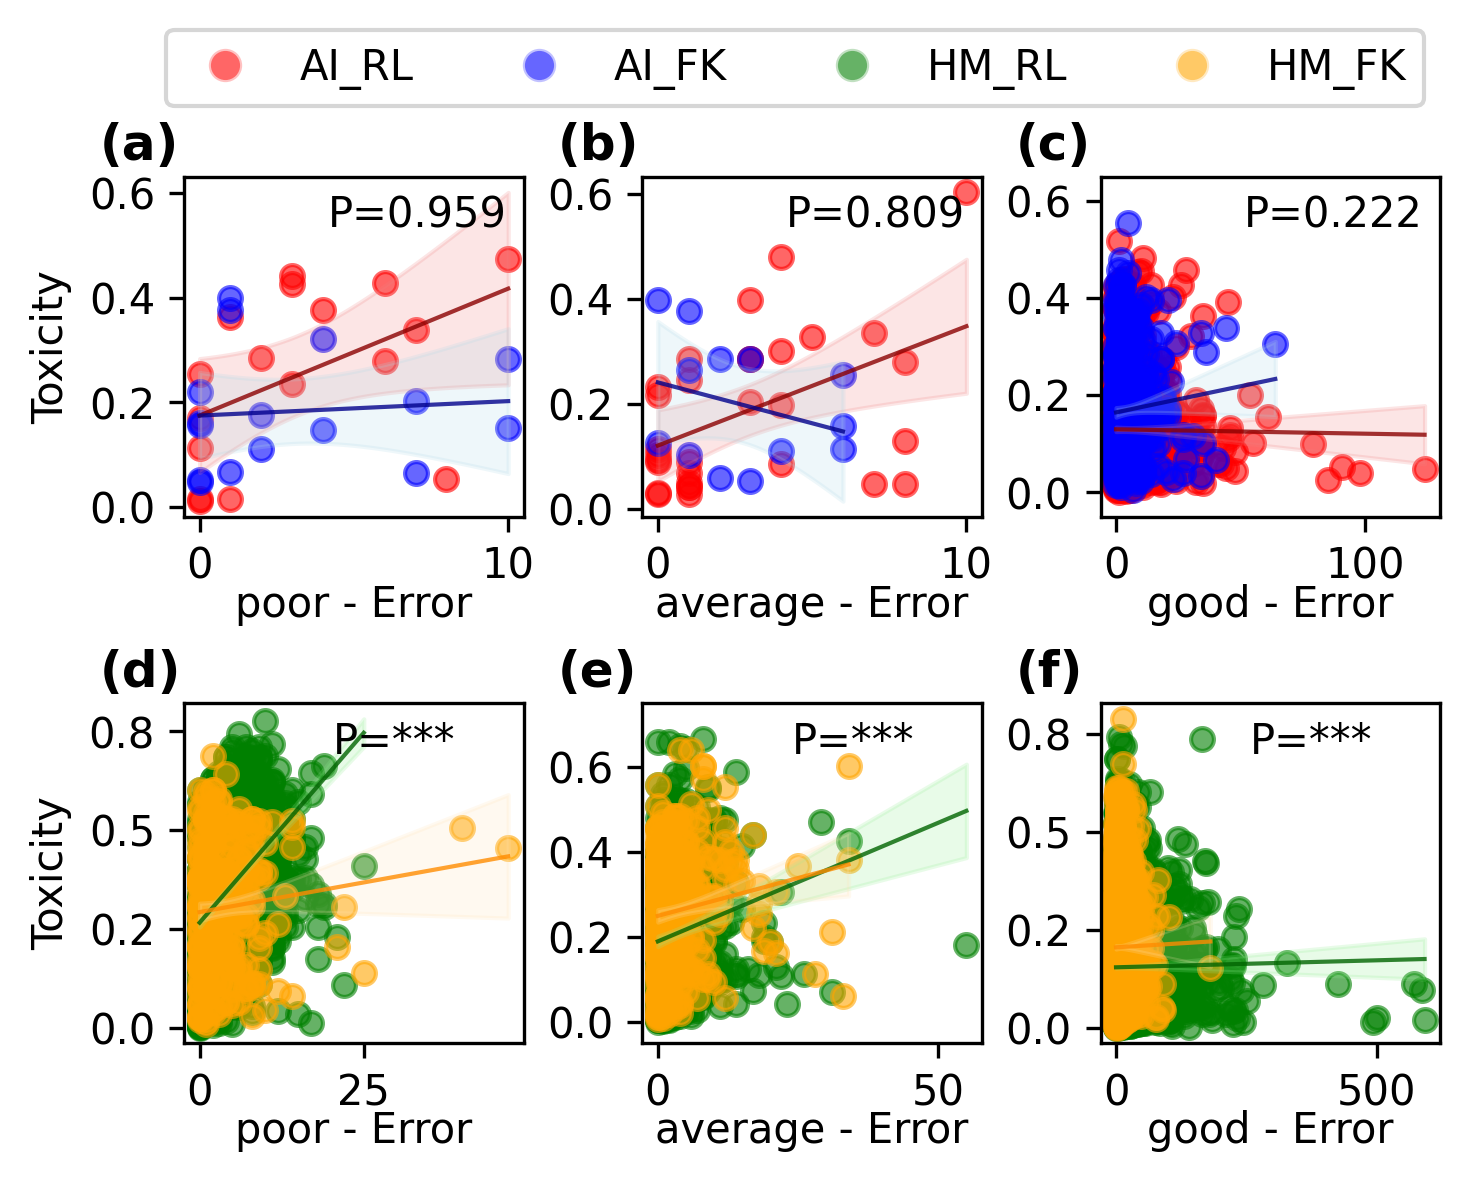

In [9]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from scipy.stats import ks_2samp, norm, linregress, t
from matplotlib.ticker import FormatStrFormatter


def add_regression_line_and_ci(ax, x_data, y_data, color='gray', alpha=0.3, line_color='black', line_width=1):
    """
    Add regression line and confidence interval to subplot
    
    Parameters:
    ax: matplotlib axis object
    x_data: x-axis data
    y_data: y-axis data
    color: confidence interval color
    alpha: confidence interval transparency
    line_color: regression line color
    line_width: regression line width
    """
    x_array = np.array(x_data)
    y_array = np.array(y_data)
    
    mask = ~(np.isnan(x_array) | np.isnan(y_array))
    x_clean = x_array[mask]
    y_clean = y_array[mask]
    
    if len(x_clean) < 3:
        return
    
    slope, intercept, r_value, p_value, std_err = linregress(x_clean, y_clean)
    
    x_line = np.linspace(x_clean.min(), x_clean.max(), 100)
    y_line = slope * x_line + intercept
    
    ax.plot(x_line, y_line, color=line_color, linewidth=line_width, alpha=0.8)
    
    n = len(x_clean)
    x_mean = np.mean(x_clean)
    
    y_pred = slope * x_clean + intercept
    residuals = y_clean - y_pred
    mse = np.sum(residuals**2) / (n - 2)
    
    t_val = t.ppf(0.975, n - 2)
    
    sxx = np.sum((x_clean - x_mean)**2)
    se = np.sqrt(mse * (1/n + (x_line - x_mean)**2 / sxx))
    
    y_pred_line = slope * x_line + intercept
    ci = t_val * se
    
    ax.fill_between(x_line, y_pred_line - ci, y_pred_line + ci, 
                    alpha=alpha, color=color)

fig, axes = plt.subplots(2, 3, figsize=(5, 4), dpi=300)

for i,Q in zip([0,1,2],['poor', 'average', 'good']):
    ai_rl_mask = (data['content_quality_finally']==Q)&(data['MY_AI']==1)&(data['MY_FK']==0)
    ai_fk_mask = (data['content_quality_finally']==Q)&(data['MY_AI']==1)&(data['MY_FK']==1)    
    
    axes[0,i].scatter(data[ai_rl_mask]['error_counts'], data[ai_rl_mask]['toxicity'], 
               alpha=0.6, s=30, color='red', label='AI_RL')
    
    axes[0,i].scatter(data[ai_fk_mask]['error_counts'], data[ai_fk_mask]['toxicity'], 
               alpha=0.6, s=30, color='b', label='AI_FK')
    
    ai_fk_mean = (data[ai_fk_mask]['toxicity'].mean(), data[ai_fk_mask]['error_counts'].mean())
    ai_rl_mean = (data[ai_rl_mask]['toxicity'].mean(), data[ai_rl_mask]['error_counts'].mean())
    
    if np.sum(ai_rl_mask) > 2:
        add_regression_line_and_ci(axes[0,i], data[ai_rl_mask]['error_counts'], data[ai_rl_mask]['toxicity'],
                                   color='lightcoral', alpha=0.2, line_color='darkred', line_width=1)
    
    if np.sum(ai_fk_mask) > 2:
        add_regression_line_and_ci(axes[0,i], data[ai_fk_mask]['error_counts'], data[ai_fk_mask]['toxicity'],
                                   color='lightblue', alpha=0.2, line_color='darkblue', line_width=1)
    
    print(Q,' ',ai_fk_mean[1],ai_rl_mean[1])
    axes[0,i].set_xlabel(Q+' - Error', labelpad=-1)
    
for i,Q in zip([0,1,2],['poor', 'average', 'good']):
    hm_rl_mask = (data['content_quality_finally']==Q)&(data['MY_AI']==0)&(data['MY_FK']==0)
    hm_fk_mask = (data['content_quality_finally']==Q)&(data['MY_AI']==0)&(data['MY_FK']==1)  
    axes[1,i].scatter(data[hm_rl_mask]['error_counts'], data[hm_rl_mask]['toxicity'],
               alpha=0.6, s=30, color='green', label='HM_RL')
    
    axes[1,i].scatter(data[hm_fk_mask]['error_counts'], data[hm_fk_mask]['toxicity'],
               alpha=0.6, s=30, color='orange', label='HM_FK')
    
    hm_fk_mean = (data[hm_fk_mask]['toxicity'].mean(), data[hm_fk_mask]['error_counts'].mean())
    hm_rl_mean = (data[hm_rl_mask]['toxicity'].mean(), data[hm_rl_mask]['error_counts'].mean())
    
    if np.sum(hm_rl_mask) > 2:
        add_regression_line_and_ci(axes[1,i], data[hm_rl_mask]['error_counts'], data[hm_rl_mask]['toxicity'],
                                   color='lightgreen', alpha=0.2, line_color='darkgreen', line_width=1)
    
    if np.sum(hm_fk_mask) > 2:
        add_regression_line_and_ci(axes[1,i], data[hm_fk_mask]['error_counts'], data[hm_fk_mask]['toxicity'],
                                   color='moccasin', alpha=0.2, line_color='darkorange', line_width=1)
    
    print(Q,'-',hm_fk_mean[1],hm_rl_mean[1])
    axes[1,i].set_xlabel(Q+' - Error', labelpad=-1)

axes[0,2].set_ylim(-0.05, 0.65)
axes[1,1].set_ylim(-0.05, 0.75)

axes[0,0].set_ylabel('Toxicity')
axes[1,0].set_ylabel('Toxicity')


statistic, p_value = ks_2samp(data_error[(data_error['content_quality_finally']=='poor')&(data_error['MY_AI']==1)&(data_error['MY_FK']==1)]['error_counts'], data_error[(data_error['content_quality_finally']=='poor')&(data_error['MY_AI']==1)&(data_error['MY_FK']==0)]['error_counts'])
pv = format(p_value, '.3f')
axes[0,0].text(0.95, 0.95, 'P='+str(pv), transform=axes[0,0].transAxes, verticalalignment='top', horizontalalignment='right')

statistic, p_value = ks_2samp(data_error[(data_error['content_quality_finally']=='average')&(data_error['MY_AI']==1)&(data_error['MY_FK']==1)]['error_counts'], data_error[(data_error['content_quality_finally']=='average')&(data_error['MY_AI']==1)&(data_error['MY_FK']==0)]['error_counts'])
pv = format(p_value, '.3f')
axes[0,1].text(0.95, 0.95, 'P='+str(pv), transform=axes[0,1].transAxes, verticalalignment='top', horizontalalignment='right')

statistic, p_value = ks_2samp(data_error[(data_error['content_quality_finally']=='good')&(data_error['MY_AI']==1)&(data_error['MY_FK']==1)]['error_counts'], data_error[(data_error['content_quality_finally']=='good')&(data_error['MY_AI']==1)&(data_error['MY_FK']==0)]['error_counts'])
pv = format(p_value, '.3f')
axes[0,2].text(0.95, 0.95, 'P='+str(pv), transform=axes[0,2].transAxes, verticalalignment='top', horizontalalignment='right')

# The following content is notable, and the function is no longer converted to a simple representation
axes[1,0].text(0.80, 0.95, 'P=***', transform=axes[1,0].transAxes, verticalalignment='top', horizontalalignment='right')
axes[1,1].text(0.80, 0.95, 'P=***', transform=axes[1,1].transAxes, verticalalignment='top', horizontalalignment='right')
axes[1,2].text(0.80, 0.95, 'P=***', transform=axes[1,2].transAxes, verticalalignment='top', horizontalalignment='right')

plt.tight_layout()
handles, labels = [], []
for ax in axes.flat:
    h, l = ax.get_legend_handles_labels()
    handles.extend(h)
    labels.extend(l)

unique_labels = []
unique_handles = []
for handle, label in zip(handles, labels):
    if label not in unique_labels:
        unique_labels.append(label)
        unique_handles.append(handle)
from matplotlib.lines import Line2D

legend_handles = [
    Line2D([0], [0], marker='o', color='w', label=label,
           markerfacecolor=handle.get_facecolor()[0], markersize=8)
    for label, handle in zip(unique_labels, unique_handles)
]

fig.legend(legend_handles, unique_labels, loc='upper center', bbox_to_anchor=(0.54, 0.99), ncol=4)

plt.subplots_adjust(wspace=0.35,hspace=0.55)
plt.subplots_adjust(top=0.85)

axes[0,0].text(-0.25, 1.05, '(a)', fontsize=12, transform=axes[0,0].transAxes, fontweight='bold')
axes[0,1].text(-0.25, 1.05, '(b)', fontsize=12, transform=axes[0,1].transAxes, fontweight='bold')
axes[0,2].text(-0.25, 1.05, '(c)', fontsize=12, transform=axes[0,2].transAxes, fontweight='bold')
axes[1,0].text(-0.25, 1.05, '(d)', fontsize=12, transform=axes[1,0].transAxes, fontweight='bold')
axes[1,1].text(-0.25, 1.05, '(e)', fontsize=12, transform=axes[1,1].transAxes, fontweight='bold')
axes[1,2].text(-0.25, 1.05, '(f)', fontsize=12, transform=axes[1,2].transAxes, fontweight='bold')

axes[1,0].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
axes[1,2].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

# plt.savefig("fig/toxi_error_data.jpg", dpi=300)
# plt.savefig("fig/toxi_error_data.svg", dpi=300)
plt.savefig("fig/toxi_error_data.eps", dpi=300)
# plt.savefig("fig/toxi_error_data.pdf", dpi=300)

plt.show()


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


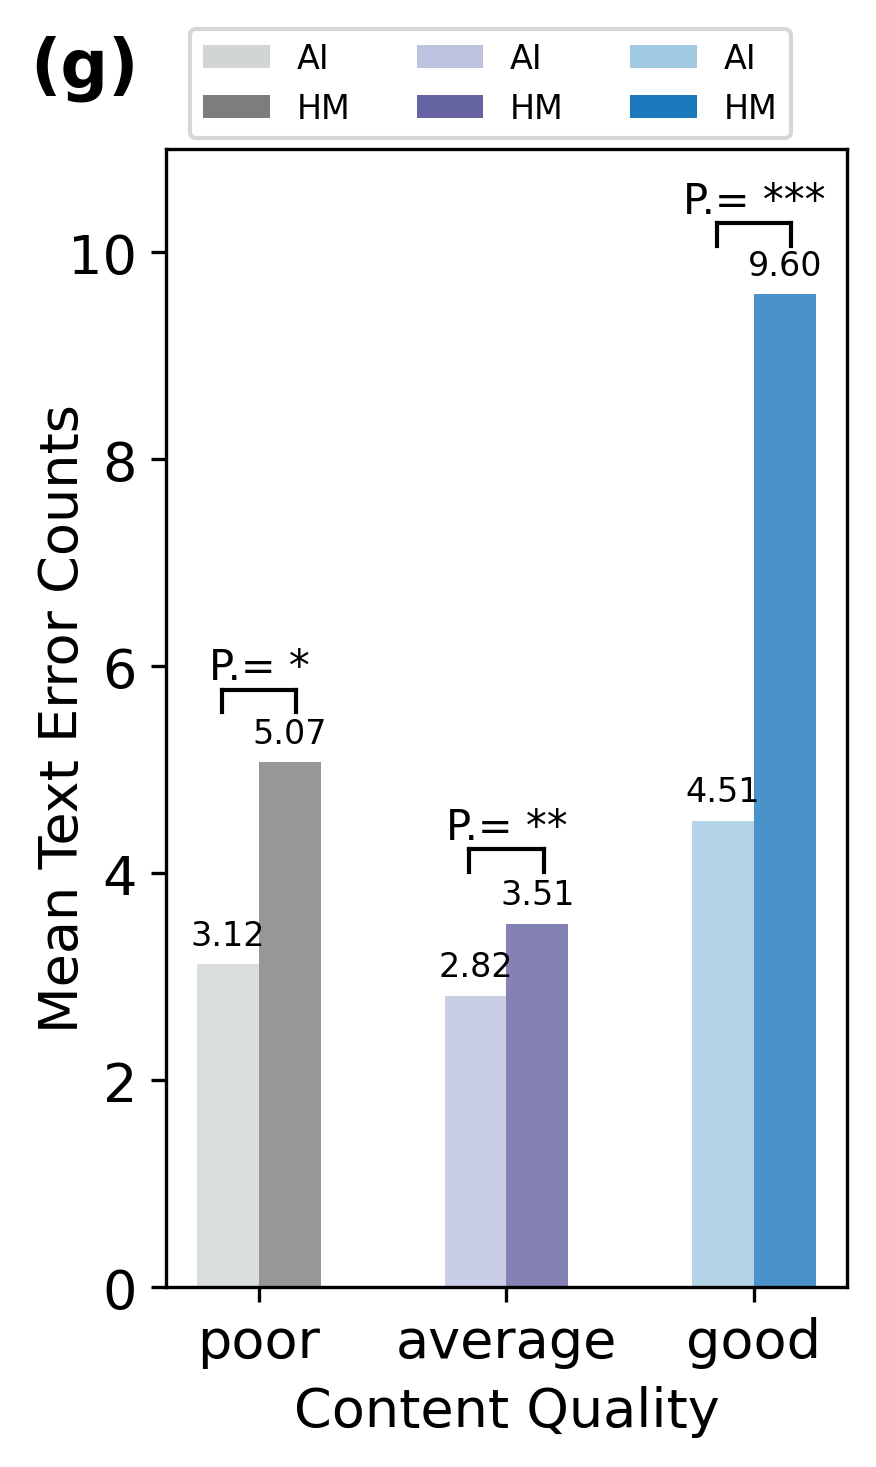

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import ks_2samp, norm
from scipy import stats
from matplotlib.patches import Patch

fig, ax = plt.subplots(figsize=(3, 5),dpi=300)

qualities = ['poor', 'average', 'good']
ai_means = []
hm_means = []


c_lists = ['#D1D6D4','#7D7C7F','#BDC2DE','#6663A2','#A2C9E2','#1B78BD']
cc = 0
for Q in qualities:
    
    AI = data_error[(data_error['content_quality_finally']==Q)&(data_error['MY_AI'] == 1)]['error_counts']
    HM = data_error[(data_error['content_quality_finally']==Q)&(data_error['MY_AI'] == 0)]['error_counts']
    
    ai_means.append(AI.mean())
    hm_means.append(HM.mean())
    
#     bars1 = ax.bar(x - width/2, AI.mean(), width, label='AI', alpha=0.8,color = c_lists[cc])
#     bars2 = ax.bar(x + width/2, HM.mean(), width, label='HM', alpha=0.8,color = c_lists[cc+1])
#     cc = cc+1
x = np.arange(len(qualities)) 
width = 0.25  


bars1 = ax.bar(x - width/2, ai_means, width, label='AI', alpha=0.8, 
               color=[c_lists[0], c_lists[2], c_lists[4]])
bars2 = ax.bar(x + width/2, hm_means, width, label='HM', alpha=0.8,
               color=[c_lists[1], c_lists[3], c_lists[5]])



legend_elements = [Patch(facecolor=c_lists[0], label='AI'),
                   Patch(facecolor=c_lists[1], label='HM'),
                   Patch(facecolor=c_lists[2], label='AI'), 
                   Patch(facecolor=c_lists[3], label='HM'),
                   Patch(facecolor=c_lists[4], label='AI'),
                   Patch(facecolor=c_lists[5], label='HM')]
ax.legend(handles=legend_elements, fontsize=8, loc='upper left', bbox_to_anchor=(0.01, 1.12),ncol=3)


def add_value_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom',fontsize=8)

trans = ax.get_xaxis_transform()
w_statistic, p_value = ks_2samp(data_error[(data_error['content_quality_finally']=='poor')&(data_error['MY_AI'] == 1)]['error_counts']
                                , data_error[(data_error['content_quality_finally']=='poor')&(data_error['MY_AI'] == 0)]['error_counts'])
x1, x2 = -0.15, 0.15
p_text = "P.= *"#+format(p_value, '.3f')
y0 = 0.525      
h = 0.02       
ax.plot([x1, x2], [y0, y0],
         transform=trans, clip_on=False,
         color='black', lw=1)
ax.plot([x1, x1], [y0, y0-h],
         transform=trans, clip_on=False,
         color='black', lw=1)
ax.plot([x2, x2], [y0, y0-h],
         transform=trans, clip_on=False,
         color='black', lw=1)
ax.text((x1+x2)/2, y0+0.001, p_text,
         transform=trans, clip_on=False,
         ha='center', va='bottom', fontsize=10)
        
w_statistic, p_value = stats.ks_2samp(data_error[(data_error['content_quality_finally']=='average')&(data_error['MY_AI'] == 1)]['error_counts']
                                , data_error[(data_error['content_quality_finally']=='average')&(data_error['MY_AI'] == 0)]['error_counts'])
x1, x2 = 0.85, 1.15
p_text = "P.= **"#+format(p_value, '.3f')
y0 = 0.385      
h = 0.02      
ax.plot([x1, x2], [y0, y0],
         transform=trans, clip_on=False,
         color='black', lw=1)
ax.plot([x1, x1], [y0, y0-h],
         transform=trans, clip_on=False,
         color='black', lw=1)
ax.plot([x2, x2], [y0, y0-h],
         transform=trans, clip_on=False,
         color='black', lw=1)
ax.text((x1+x2)/2, y0+0.001, p_text,
         transform=trans, clip_on=False,
         ha='center', va='bottom', fontsize=10)
        
        
w_statistic, p_value = ks_2samp(data_error[(data_error['content_quality_finally']=='good')&(data_error['MY_AI'] == 1)]['error_counts']
                                , data_error[(data_error['content_quality_finally']=='good')&(data_error['MY_AI'] == 0)]['error_counts'])
x1, x2 = 1.85, 2.15
p_text = "P.= ***"

y0 = 0.935      
h = 0.02      
ax.plot([x1, x2], [y0, y0],
         transform=trans, clip_on=False,
         color='black', lw=1)
ax.plot([x1, x1], [y0, y0-h],
         transform=trans, clip_on=False,
         color='black', lw=1)
ax.plot([x2, x2], [y0, y0-h],
         transform=trans, clip_on=False,
         color='black', lw=1)
ax.text((x1+x2)/2, y0+0.001, p_text,
         transform=trans, clip_on=False,
         ha='center', va='bottom', fontsize=10)
    
    
add_value_labels(bars1)
add_value_labels(bars2)
ax.set_ylim(0, 11)  


ax.set_xlabel('Content Quality', fontsize=13)
ax.set_ylabel('Mean Text Error Counts', fontsize=13, labelpad=-5)
ax.set_xticks(x)
ax.set_xticklabels(qualities)
ax.tick_params(axis='both', which='major', labelsize=13)

plt.tight_layout()
ax.text(-0.20, 1.055, '(g)', transform=ax.transAxes, fontsize=16, fontweight='bold')


# plt.savefig("fig/2error_data.jpg", dpi=300)
# plt.savefig("fig/2error_data.svg", dpi=300)
plt.savefig("fig/2error_data.eps", dpi=300)
# plt.savefig("fig/2error_data.pdf", dpi=300)

plt.show()

# plt.savefig('error_comparison.png', dpi=300, bbox_inches='tight')

In [11]:
import requests
import json
import hashlib
import base64
import hmac
import datetime
import uuid
import pandas as pd
import numpy as np
import ast
data = pd.read_csv('MCFEND_for_classification.csv')
data_error = pd.read_csv('mcfend_error_check.csv')
#data_asl = pd.read_csv('asl_data.csv')
rest = data_error[(data_error['error_details']!=-1) & (data_error['error_details']!='-1')& (data_error['error_details']!='-1')&(data_error['error_details'].isna()==False)].index.tolist()
#data_asl = data_asl.loc[rest,:].reset_index(drop=True)
data_error = data_error.loc[rest,:].reset_index(drop=True)
data = data.loc[rest,:].reset_index(drop=True)
#data_error['Average Sentence Length'] = data_asl['Average Sentence Length']


poor   0.9869402985074627 1.36
average   1.0695634434924521 1.4670184696569921
good   0.9015637016149706 1.390480032271077
poor - 0.47023605884365377 0.5404191616766467
average - 0.4830387004300048 0.6871945259042033
good - 0.7391640866873065 0.8406593406593407


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


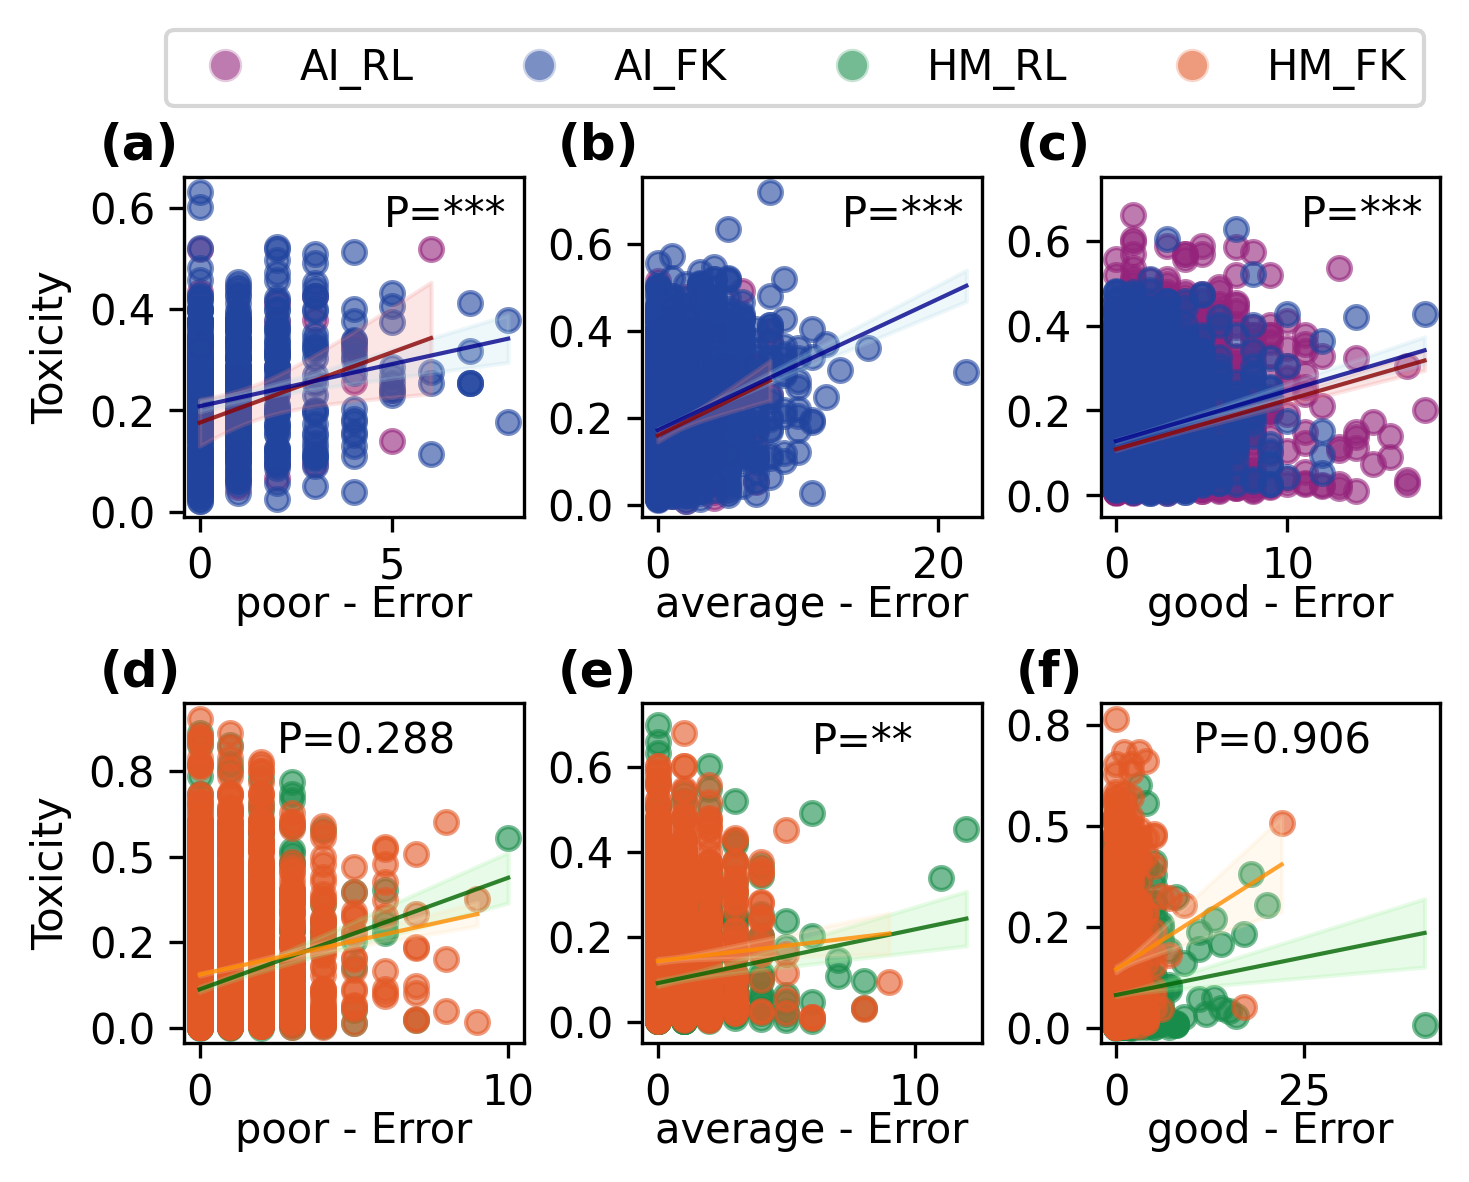

In [13]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from scipy.stats import ks_2samp, norm, linregress, t
from matplotlib.ticker import FormatStrFormatter

def add_regression_line_and_ci(ax, x_data, y_data, color='gray', alpha=0.3, line_color='black', line_width=1):
    x_array = np.array(x_data)
    y_array = np.array(y_data)
    mask = ~(np.isnan(x_array) | np.isnan(y_array))
    x_clean = x_array[mask]
    y_clean = y_array[mask]
    if len(x_clean) < 3:
        return
    slope, intercept, r_value, p_value, std_err = linregress(x_clean, y_clean)
    x_line = np.linspace(x_clean.min(), x_clean.max(), 100)
    y_line = slope * x_line + intercept
    ax.plot(x_line, y_line, color=line_color, linewidth=line_width, alpha=0.8)
    n = len(x_clean)
    x_mean = np.mean(x_clean)
    y_pred = slope * x_clean + intercept
    residuals = y_clean - y_pred
    mse = np.sum(residuals**2) / (n - 2)
    t_val = t.ppf(0.975, n - 2)
    sxx = np.sum((x_clean - x_mean)**2)
    se = np.sqrt(mse * (1/n + (x_line - x_mean)**2 / sxx))
    y_pred_line = slope * x_line + intercept
    ci = t_val * se
    ax.fill_between(x_line, y_pred_line - ci, y_pred_line + ci, alpha=alpha, color=color)

fig, axes = plt.subplots(2, 3, figsize=(5, 4), dpi=300)

for i, Q in zip([0,1,2], ['poor', 'average', 'good']):
    ai_rl_mask = (data['content_quality_finally']==Q) & (data['MY_AI']==1) & (data['MY_FK']==0)
    ai_fk_mask = (data['content_quality_finally']==Q) & (data['MY_AI']==1) & (data['MY_FK']==1)
    axes[0,i].scatter(data[ai_rl_mask]['error_counts'], data[ai_rl_mask]['toxicity'], alpha=0.6, s=30, color='#94237B', label='AI_RL')
    axes[0,i].scatter(data[ai_fk_mask]['error_counts'], data[ai_fk_mask]['toxicity'], alpha=0.6, s=30, color='#21449E', label='AI_FK')
    ai_fk_mean = (data[ai_fk_mask]['toxicity'].mean(), data[ai_fk_mask]['error_counts'].mean())
    ai_rl_mean = (data[ai_rl_mask]['toxicity'].mean(), data[ai_rl_mask]['error_counts'].mean())
    if np.sum(ai_rl_mask) > 2:
        add_regression_line_and_ci(axes[0,i], data[ai_rl_mask]['error_counts'], data[ai_rl_mask]['toxicity'], color='lightcoral', alpha=0.2, line_color='darkred', line_width=1)
    if np.sum(ai_fk_mask) > 2:
        add_regression_line_and_ci(axes[0,i], data[ai_fk_mask]['error_counts'], data[ai_fk_mask]['toxicity'], color='lightblue', alpha=0.2, line_color='darkblue', line_width=1)
    print(Q, ' ', ai_fk_mean[1], ai_rl_mean[1])
    axes[0,i].set_xlabel(Q+' - Error', labelpad=-1)

for i, Q in zip([0,1,2], ['poor', 'average', 'good']):
    hm_rl_mask = (data['content_quality_finally']==Q) & (data['MY_AI']==0) & (data['MY_FK']==0)
    hm_fk_mask = (data['content_quality_finally']==Q) & (data['MY_AI']==0) & (data['MY_FK']==1)
    axes[1,i].scatter(data[hm_rl_mask]['error_counts'], data[hm_rl_mask]['toxicity'], alpha=0.6, s=30, color='#188C4A', label='HM_RL')
    axes[1,i].scatter(data[hm_fk_mask]['error_counts'], data[hm_fk_mask]['toxicity'], alpha=0.6, s=30, color='#E35926', label='HM_FK')
    hm_fk_mean = (data[hm_fk_mask]['toxicity'].mean(), data[hm_fk_mask]['error_counts'].mean())
    hm_rl_mean = (data[hm_rl_mask]['toxicity'].mean(), data[hm_rl_mask]['error_counts'].mean())
    if np.sum(hm_rl_mask) > 2:
        add_regression_line_and_ci(axes[1,i], data[hm_rl_mask]['error_counts'], data[hm_rl_mask]['toxicity'], color='lightgreen', alpha=0.2, line_color='darkgreen', line_width=1)
    if np.sum(hm_fk_mask) > 2:
        add_regression_line_and_ci(axes[1,i], data[hm_fk_mask]['error_counts'], data[hm_fk_mask]['toxicity'], color='moccasin', alpha=0.2, line_color='darkorange', line_width=1)
    print(Q,'-', hm_fk_mean[1], hm_rl_mean[1])
    axes[1,i].set_xlabel(Q+' - Error', labelpad=-1)

axes[0,2].set_ylim(-0.05, 0.75)
axes[1,1].set_ylim(-0.05, 0.75)
axes[0,0].set_ylabel('Toxicity')
axes[1,0].set_ylabel('Toxicity')

axes[0,0].text(0.95, 0.95, 'P=***', transform=axes[0,0].transAxes, verticalalignment='top', horizontalalignment='right')
axes[0,1].text(0.95, 0.95, 'P=***', transform=axes[0,1].transAxes, verticalalignment='top', horizontalalignment='right')
axes[0,2].text(0.95, 0.95, 'P=***', transform=axes[0,2].transAxes, verticalalignment='top', horizontalalignment='right')

statistic, p_value = ks_2samp(data[(data['content_quality_finally']=='poor')&(data['MY_AI']==0)&(data['MY_FK']==1)]['error_counts'], data[(data['content_quality_finally']=='poor')&(data['MY_AI']==0)&(data['MY_FK']==0)]['error_counts'])
pv=format(p_value, '.3f')

axes[1,0].text(0.80, 0.95, 'P='+str(pv), transform=axes[1,0].transAxes, verticalalignment='top', horizontalalignment='right')
axes[1,1].text(0.80, 0.95, 'P=**', transform=axes[1,1].transAxes, verticalalignment='top', horizontalalignment='right')

statistic, p_value = ks_2samp(data[(data['content_quality_finally']=='good')&(data['MY_AI']==0)&(data['MY_FK']==1)]['error_counts'], data[(data['content_quality_finally']=='good')&(data['MY_AI']==0)&(data['MY_FK']==0)]['error_counts'])
pv=format(p_value, '.3f')
axes[1,2].text(0.80, 0.95,  'P='+str(pv), transform=axes[1,2].transAxes, verticalalignment='top', horizontalalignment='right')

plt.tight_layout()
handles, labels = [], []
for ax in axes.flat:
    h, l = ax.get_legend_handles_labels()
    handles.extend(h)
    labels.extend(l)

unique_labels, unique_handles = [], []
for handle, label in zip(handles, labels):
    if label not in unique_labels:
        unique_labels.append(label)
        unique_handles.append(handle)

from matplotlib.lines import Line2D
legend_handles = [Line2D([0], [0], marker='o', color='w', label=label, markerfacecolor=handle.get_facecolor()[0], markersize=8) for label, handle in zip(unique_labels, unique_handles)]
fig.legend(legend_handles, unique_labels, loc='upper center', bbox_to_anchor=(0.54, 0.99), ncol=4)
plt.subplots_adjust(wspace=0.35, hspace=0.55)
plt.subplots_adjust(top=0.85)

for j, label in enumerate(['(a)','(b)','(c)','(d)','(e)','(f)']):
    axes[j//3, j%3].text(-0.25, 1.05, label, fontsize=12, transform=axes[j//3, j%3].transAxes, fontweight='bold')

axes[1,0].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
axes[1,2].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

# plt.savefig("fig/toxi_error_mcfend.jpg", dpi=300)
# plt.savefig("fig/toxi_error_mcfend.svg", dpi=300)
plt.savefig("fig/toxi_error_mcfend.eps", dpi=300)
# plt.savefig("fig/toxi_error_mcfend.pdf", dpi=300)
plt.show()


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


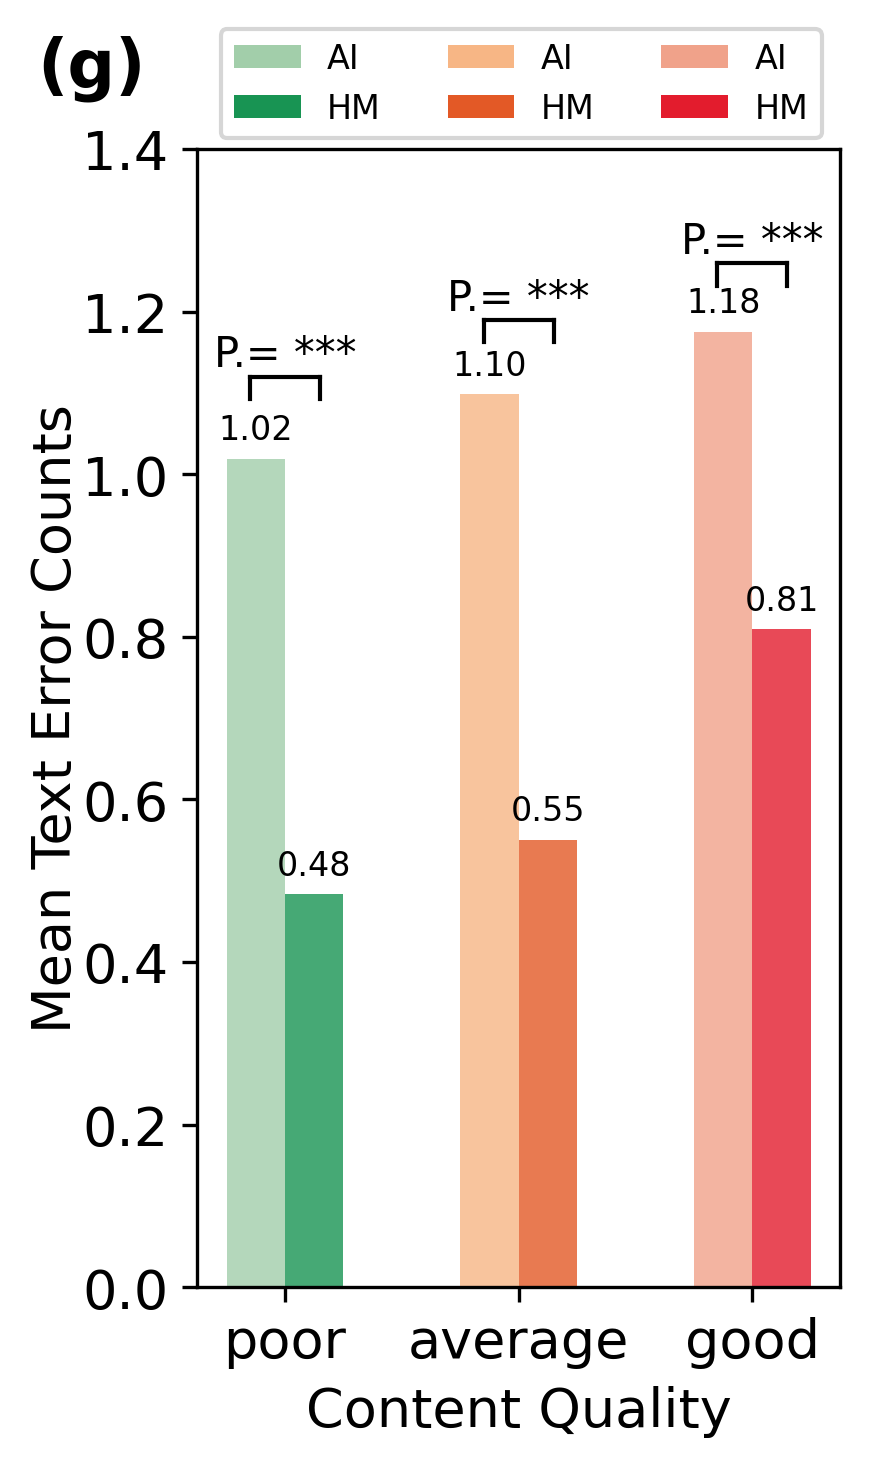

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import ks_2samp, norm, stats
from matplotlib.patches import Patch

fig, ax = plt.subplots(figsize=(3, 5), dpi=300)

qualities = ['poor', 'average', 'good']
ai_means, hm_means = [], []
c_lists = ['#A2CEAA','#189453','#F7B685','#E35926','#F0A28A','#E31C2D']

for Q in qualities:
    AI = data_error[(data_error['content_quality_finally']==Q) & (data_error['MY_AI']==1)]['error_counts']
    HM = data_error[(data_error['content_quality_finally']==Q) & (data_error['MY_AI']==0)]['error_counts']
    ai_means.append(AI.mean())
    hm_means.append(HM.mean())

x = np.arange(len(qualities))
width = 0.25

bars1 = ax.bar(x - width/2, ai_means, width, label='AI', alpha=0.8, color=[c_lists[0], c_lists[2], c_lists[4]])
bars2 = ax.bar(x + width/2, hm_means, width, label='HM', alpha=0.8, color=[c_lists[1], c_lists[3], c_lists[5]])

legend_elements = [Patch(facecolor=c_lists[i], label=label) for i, label in enumerate(['AI','HM','AI','HM','AI','HM'])]
ax.legend(handles=legend_elements, fontsize=8, loc='upper left', bbox_to_anchor=(0.01, 1.12), ncol=3)

def add_value_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width()/2, height),
                    xytext=(0,3), textcoords="offset points", ha='center', va='bottom', fontsize=8)

trans = ax.get_xaxis_transform()
ks_positions = [(-0.15,0.15,0.80), (0.85,1.15,0.85), (1.85,2.15,0.90)]
for i, Q in enumerate(qualities):
    x1, x2, y0 = ks_positions[i]
    w_statistic, p_value = ks_2samp(data_error[(data_error['content_quality_finally']==Q) & (data_error['MY_AI']==1)]['error_counts'],
                                    data_error[(data_error['content_quality_finally']==Q) & (data_error['MY_AI']==0)]['error_counts'])
    p_text = "P.= ***"
    h = 0.02
    ax.plot([x1, x2], [y0, y0], transform=trans, clip_on=False, color='black', lw=1)
    ax.plot([x1, x1], [y0, y0-h], transform=trans, clip_on=False, color='black', lw=1)
    ax.plot([x2, x2], [y0, y0-h], transform=trans, clip_on=False, color='black', lw=1)
    ax.text((x1+x2)/2, y0+0.001, p_text, transform=trans, clip_on=False, ha='center', va='bottom', fontsize=10)

add_value_labels(bars1)
add_value_labels(bars2)
ax.set_ylim(0, 1.4)
ax.set_xlabel('Content Quality', fontsize=13)
ax.set_ylabel('Mean Text Error Counts', fontsize=13, labelpad=0)
ax.set_xticks(x)
ax.set_xticklabels(qualities)
ax.tick_params(axis='both', which='major', labelsize=13)
plt.tight_layout()
ax.text(-0.25, 1.055, '(g)', transform=ax.transAxes, fontsize=16, fontweight='bold')

# plt.savefig("fig/2error_mcfend.jpg", dpi=300)
# plt.savefig("fig/2error_mcfend.svg", dpi=300)
plt.savefig("fig/2error_mcfend.eps", dpi=300)
# plt.savefig("fig/2error_mcfend.pdf", dpi=300)

plt.show()


# HanLP

In [ ]:
import hanlp
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import os
import ast

os.environ['PYTORCH_CUDA_ALLOC_CONF']= 'expandable_segments:true'

os.environ['PYTORCH_CUDA_ALLOC_CONF']= 'max_split_size_mb:128'
os.environ['PYTORCH_CUDA_ALLOC_CONF']= 'garbage_collection_threshold:0.5'

HanLP = hanlp.pipeline() \
    .append(hanlp.utils.rules.split_sentence, output_key='sentences') \
    .append(hanlp.load('FINE_ELECTRA_SMALL_ZH'), output_key='tok') \
    .append(hanlp.load('PKU_POS_ELECTRA_SMALL'), output_key='pos') \
    .append(hanlp.load('PMT1_DEP_ELECTRA_SMALL', conll=0), output_key='dep', input_key='tok')\
    .append(hanlp.load('SEMEVAL16_ALL_ELECTRA_SMALL_ZH'), output_key='sdp', input_key='tok')


data = pd.read_csv('merge_22075_with_all_model.csv')

# CheapFK_ = pd.read_csv('mcfend_9339_Fake_for_CheapFake_Processed.csv',dtype=str)
# CheapAI_ = pd.read_csv('mcfend_5387_real_for_CheapAI_Processed.csv',dtype=str)
# CheapFK_.drop(columns=['AI_FK_title_length', 'AI_FK_content_length', 'HM_FK_title_length', 'HM_FK_content_length'], inplace=True)
# CheapAI_.drop(columns=['AI_RL_title_length', 'AI_RL_content_length', 'HM_RL_title_length', 'HM_RL_content_length'], inplace=True)
# data = pd.concat([CheapFK_, CheapAI_], axis=0).reset_index(drop=True)

In [ ]:
dataname = 'hanlp_data.csv'
#dataname = 'hanlp_MCFNED_or.csv'
#dataname = 'hanlp_MCFNED_gen.csv'

hanlp_data = pd.DataFrame()
hanlp_data['ContentID'] = data['ContentID']
#hanlp_data['ContentID'] = data['news_id']
hanlp_data['dep'] = None
hanlp_data['pos'] = None
hanlp_data['sdp'] = None

In [ ]:

na_double_check = hanlp_data.loc[:, 'dep'].isna()
true_indexes = na_double_check[na_double_check].index.tolist()

In [ ]:
count = 0
#This part needs to request all data 
#This part needs to request all data 
#This part needs to request all data 
#for i in range(len(data)):
for i in true_indexes:
    text = str(data['头条标题'][i])+'。'+str(data['头条内容'][i])    
    #text = str(data['title'][i])+'。'+str(data['content'][i])
    #text = str(data['AIGen_title'][i])+'。'+str(data['AIGen_content'][i])
    
    
    text = text.replace('图片来源于网络','。')
    text = text.replace(';','。')
    text = text.replace('；','。')
    text = text.replace('!','。')
    text = text.replace('！','。')
    try:
        text_lists = text.split('。')
        dep_result_all = []
        pos_result_all = []
        sdp_result_all = []
        for sub_text in text_lists:
            returns = HanLP(sub_text)
            dep_result = returns['dep']
            pos_result = returns['pos']
            sdp_result = [
                [item['deps'][0] for item in sublist]  
                for sublist in returns['sdp']                
            ]
            dep_result_all.extend(dep_result)
            pos_result_all.extend(pos_result)
            sdp_result_all.extend(sdp_result)
        hanlp_data['dep'][i] = dep_result_all
        hanlp_data['pos'][i] = pos_result_all
        hanlp_data['sdp'][i] = sdp_result_all
    
    except Exception as e:
        print(i,'ERROR：',e)
        hanlp_data['dep'][i] = None
        hanlp_data['pos'][i] = None
        hanlp_data['sdp'][i] = None        
        
        
    if count%50==0:
        print(i)
        hanlp_data.to_csv(dataname,index=None)
        print('##############')
    count = count+1
hanlp_data.to_csv(dataname,index=None)


In [ ]:
import hanlp
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import os
import ast


# Convert nested lists

hanlp_data=pd.read_csv('hanlp_data.csv')
#hanlp_data=pd.read_csv('hanlp_MCFNED_or.csv')
#hanlp_data=pd.read_csv('hanlp_MCFNED_gen.csv')

hanlp_data['dep_list'] = None
hanlp_data['pos_list'] = None
hanlp_data['sdp_list'] = None


for i in range(len(hanlp_data)):
    hanlp_data['dep_list'][i] = [item[1] for sublist in ast.literal_eval(hanlp_data['dep'][i]) for item in sublist]
    hanlp_data['sdp_list'][i] = [item[1] for sublist in ast.literal_eval(hanlp_data['sdp'][i]) for item in sublist]
    hanlp_data['pos_list'][i] = [item for sublist in ast.literal_eval(hanlp_data['pos'][i]) for item in sublist]
hanlp_data = hanlp_data.loc[:,['ContentID','dep_list','pos_list','sdp_list']]
hanlp_data.to_csv('hanlp_data_lists.csv',index=None)
# The file is about 1GB, and for ease of review, it is not run here.
# The file is about 1GB, and for ease of review, it is not run here.
# The file is about 1GB, and for ease of review, it is not run here.


In [ ]:
# The file is about 1GB, and for ease of review, it is not run here.
# The file is about 1GB, and for ease of review, it is not run here.
# The file is about 1GB, and for ease of review, it is not run here.
hanlp_data_list = pd.read_csv('hanlp_data_lists.csv')

quality_order = ['poor', 'average', 'good']
data_dep_all = []
for Q in quality_order:
    mask = (hanlp_data_list['content_quality_finally'] == Q)&(hanlp_data_list['MY_AI'] == 1)&(hanlp_data_list['MY_FK'] == 1)
    hanlp_data_AI_FK_dep = []
    for i in hanlp_data_list[mask].index.tolist():
        asts = ast.literal_eval(hanlp_data_list.loc[i,'dep_list'])
        hanlp_data_AI_FK_dep.extend(asts)
    mask = (hanlp_data_list['content_quality_finally'] == Q)&(hanlp_data_list['MY_AI'] == 1)&(hanlp_data_list['MY_FK'] == 0)
    hanlp_data_AI_RL_dep = []
    for i in hanlp_data_list[mask].index.tolist():
        asts = ast.literal_eval(hanlp_data_list.loc[i,'dep_list'])
        hanlp_data_AI_RL_dep.extend(asts)
    mask = (hanlp_data_list['content_quality_finally'] == Q)&(hanlp_data_list['MY_AI'] == 0)&(hanlp_data_list['MY_FK'] == 1)
    hanlp_data_HM_FK_dep = []
    for i in hanlp_data_list[mask].index.tolist():
        asts = ast.literal_eval(hanlp_data_list.loc[i,'dep_list'])
        hanlp_data_HM_FK_dep.extend(asts)
    mask = (hanlp_data_list['content_quality_finally'] == Q)&(hanlp_data_list['MY_AI'] == 0)&(hanlp_data_list['MY_FK'] == 0)
    hanlp_data_HM_RL_dep = []
    for i in hanlp_data_list[mask].index.tolist():
        asts = ast.literal_eval(hanlp_data_list.loc[i,'dep_list'])
        hanlp_data_HM_RL_dep.extend(asts)
    data_dep_all.append(hanlp_data_AI_FK_dep)
    data_dep_all.append(hanlp_data_AI_RL_dep)
    data_dep_all.append(hanlp_data_HM_FK_dep)
    data_dep_all.append(hanlp_data_HM_RL_dep)


In [ ]:
quality_order = ['poor', 'average', 'good']
data_pos_all = []
for Q in quality_order:
    mask = (hanlp_data_list['content_quality_finally'] == Q)&(hanlp_data_list['MY_AI'] == 1)&(hanlp_data_list['MY_FK'] == 1)
    hanlp_data_AI_FK_dep = []
    for i in hanlp_data_list[mask].index.tolist():
        asts = ast.literal_eval(hanlp_data_list.loc[i,'pos_list'])
        hanlp_data_AI_FK_dep.extend(asts)
    mask = (hanlp_data_list['content_quality_finally'] == Q)&(hanlp_data_list['MY_AI'] == 1)&(hanlp_data_list['MY_FK'] == 0)
    hanlp_data_AI_RL_dep = []
    for i in hanlp_data_list[mask].index.tolist():
        asts = ast.literal_eval(hanlp_data_list.loc[i,'pos_list'])
        hanlp_data_AI_RL_dep.extend(asts)
    mask = (hanlp_data_list['content_quality_finally'] == Q)&(hanlp_data_list['MY_AI'] == 0)&(hanlp_data_list['MY_FK'] == 1)
    hanlp_data_HM_FK_dep = []
    for i in hanlp_data_list[mask].index.tolist():
        asts = ast.literal_eval(hanlp_data_list.loc[i,'pos_list'])
        hanlp_data_HM_FK_dep.extend(asts)
    mask = (hanlp_data_list['content_quality_finally'] == Q)&(hanlp_data_list['MY_AI'] == 0)&(hanlp_data_list['MY_FK'] == 0)
    hanlp_data_HM_RL_dep = []
    for i in hanlp_data_list[mask].index.tolist():
        asts = ast.literal_eval(hanlp_data_list.loc[i,'pos_list'])
        hanlp_data_HM_RL_dep.extend(asts)
    data_pos_all.append(hanlp_data_AI_FK_dep)
    data_pos_all.append(hanlp_data_AI_RL_dep)
    data_pos_all.append(hanlp_data_HM_FK_dep)
    data_pos_all.append(hanlp_data_HM_RL_dep)

In [ ]:
quality_order = ['poor', 'average', 'good']
data_sdp_all = []
for Q in quality_order:
    mask = (hanlp_data_list['content_quality_finally'] == Q)&(hanlp_data_list['MY_AI'] == 1)&(hanlp_data_list['MY_FK'] == 1)
    hanlp_data_AI_FK_dep = []
    for i in hanlp_data_list[mask].index.tolist():
        asts = ast.literal_eval(hanlp_data_list.loc[i,'sdp_list'])
        hanlp_data_AI_FK_dep.extend(asts)
    mask = (hanlp_data_list['content_quality_finally'] == Q)&(hanlp_data_list['MY_AI'] == 1)&(hanlp_data_list['MY_FK'] == 0)
    hanlp_data_AI_RL_dep = []
    for i in hanlp_data_list[mask].index.tolist():
        asts = ast.literal_eval(hanlp_data_list.loc[i,'sdp_list'])
        hanlp_data_AI_RL_dep.extend(asts)
    mask = (hanlp_data_list['content_quality_finally'] == Q)&(hanlp_data_list['MY_AI'] == 0)&(hanlp_data_list['MY_FK'] == 1)
    hanlp_data_HM_FK_dep = []
    for i in hanlp_data_list[mask].index.tolist():
        asts = ast.literal_eval(hanlp_data_list.loc[i,'sdp_list'])
        hanlp_data_HM_FK_dep.extend(asts)
    mask = (hanlp_data_list['content_quality_finally'] == Q)&(hanlp_data_list['MY_AI'] == 0)&(hanlp_data_list['MY_FK'] == 0)
    hanlp_data_HM_RL_dep = []
    for i in hanlp_data_list[mask].index.tolist():
        asts = ast.literal_eval(hanlp_data_list.loc[i,'sdp_list'])
        hanlp_data_HM_RL_dep.extend(asts)
    data_sdp_all.append(hanlp_data_AI_FK_dep)
    data_sdp_all.append(hanlp_data_AI_RL_dep)
    data_sdp_all.append(hanlp_data_HM_FK_dep)
    data_sdp_all.append(hanlp_data_HM_RL_dep)

In [ ]:
# The file is about 500MB, and for ease of review, it is not run here.
# The file is about 500MB, and for ease of review, it is not run here.
# The file is about 500MB, and for ease of review, it is not run here.
with open('data_dep_all'+'.pkl', 'wb') as f:
    pickle.dump(data_dep_all, f)
with open('data_pos_all'+'.pkl', 'wb') as f:
    pickle.dump(data_pos_all, f)
with open('data_sdp_all'+'.pkl', 'wb') as f:
    pickle.dump(data_sdp_all, f)

# Calculating MDD

In [ ]:
# The file is about 250MB, and for ease of review, it is not run here.
# The file is about 250MB, and for ease of review, it is not run here.
# The file is about 250MB, and for ease of review, it is not run here.

hanlp_data = pd.read_csv('hanlp_MCFEND.csv')
hanlp_data_lists = pd.read_csv('hanlp_MCFEND_lists.csv')
hanlp_data['dep_DD']=None
hanlp_data['dep_MDD']=None
excluded_tags = {"PUN", "punct", "HED", "root"}

for i in range(len(hanlp_data)):
    filtered_nested_list = [
        [item for item in sublist if item[1] not in excluded_tags]
        for sublist in ast.literal_eval(hanlp_data['dep'][i])
    ]
    DD = [
        sum(abs(index - num) for index, (num, _) in enumerate(sublist, start=1))
        for sublist in filtered_nested_list
    ]
    hanlp_data['dep_DD'][i] = DD
    hanlp_data['dep_MDD'][i] = sum(DD)/(len(ast.literal_eval(hanlp_data['dep_list'][i])) - len(ast.literal_eval(hanlp_data['dep'][i])))
    if i % 100 ==0:
        print(i)
hanlp_data_lists = pd.read_csv('hanlp_MCFEND_lists.csv')
hanlp_data_lists['dep_DD'] = hanlp_data['dep_DD']
hanlp_data_lists['dep_MDD'] = hanlp_data['dep_MDD']
hanlp_data_lists = pd.read_csv('hanlp_MCFEND_lists.csv')


# Fig. 8.  CDF curves for different types of data. (a) and (b) represent the CDF on Toutiao and MCFEND, respectively.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


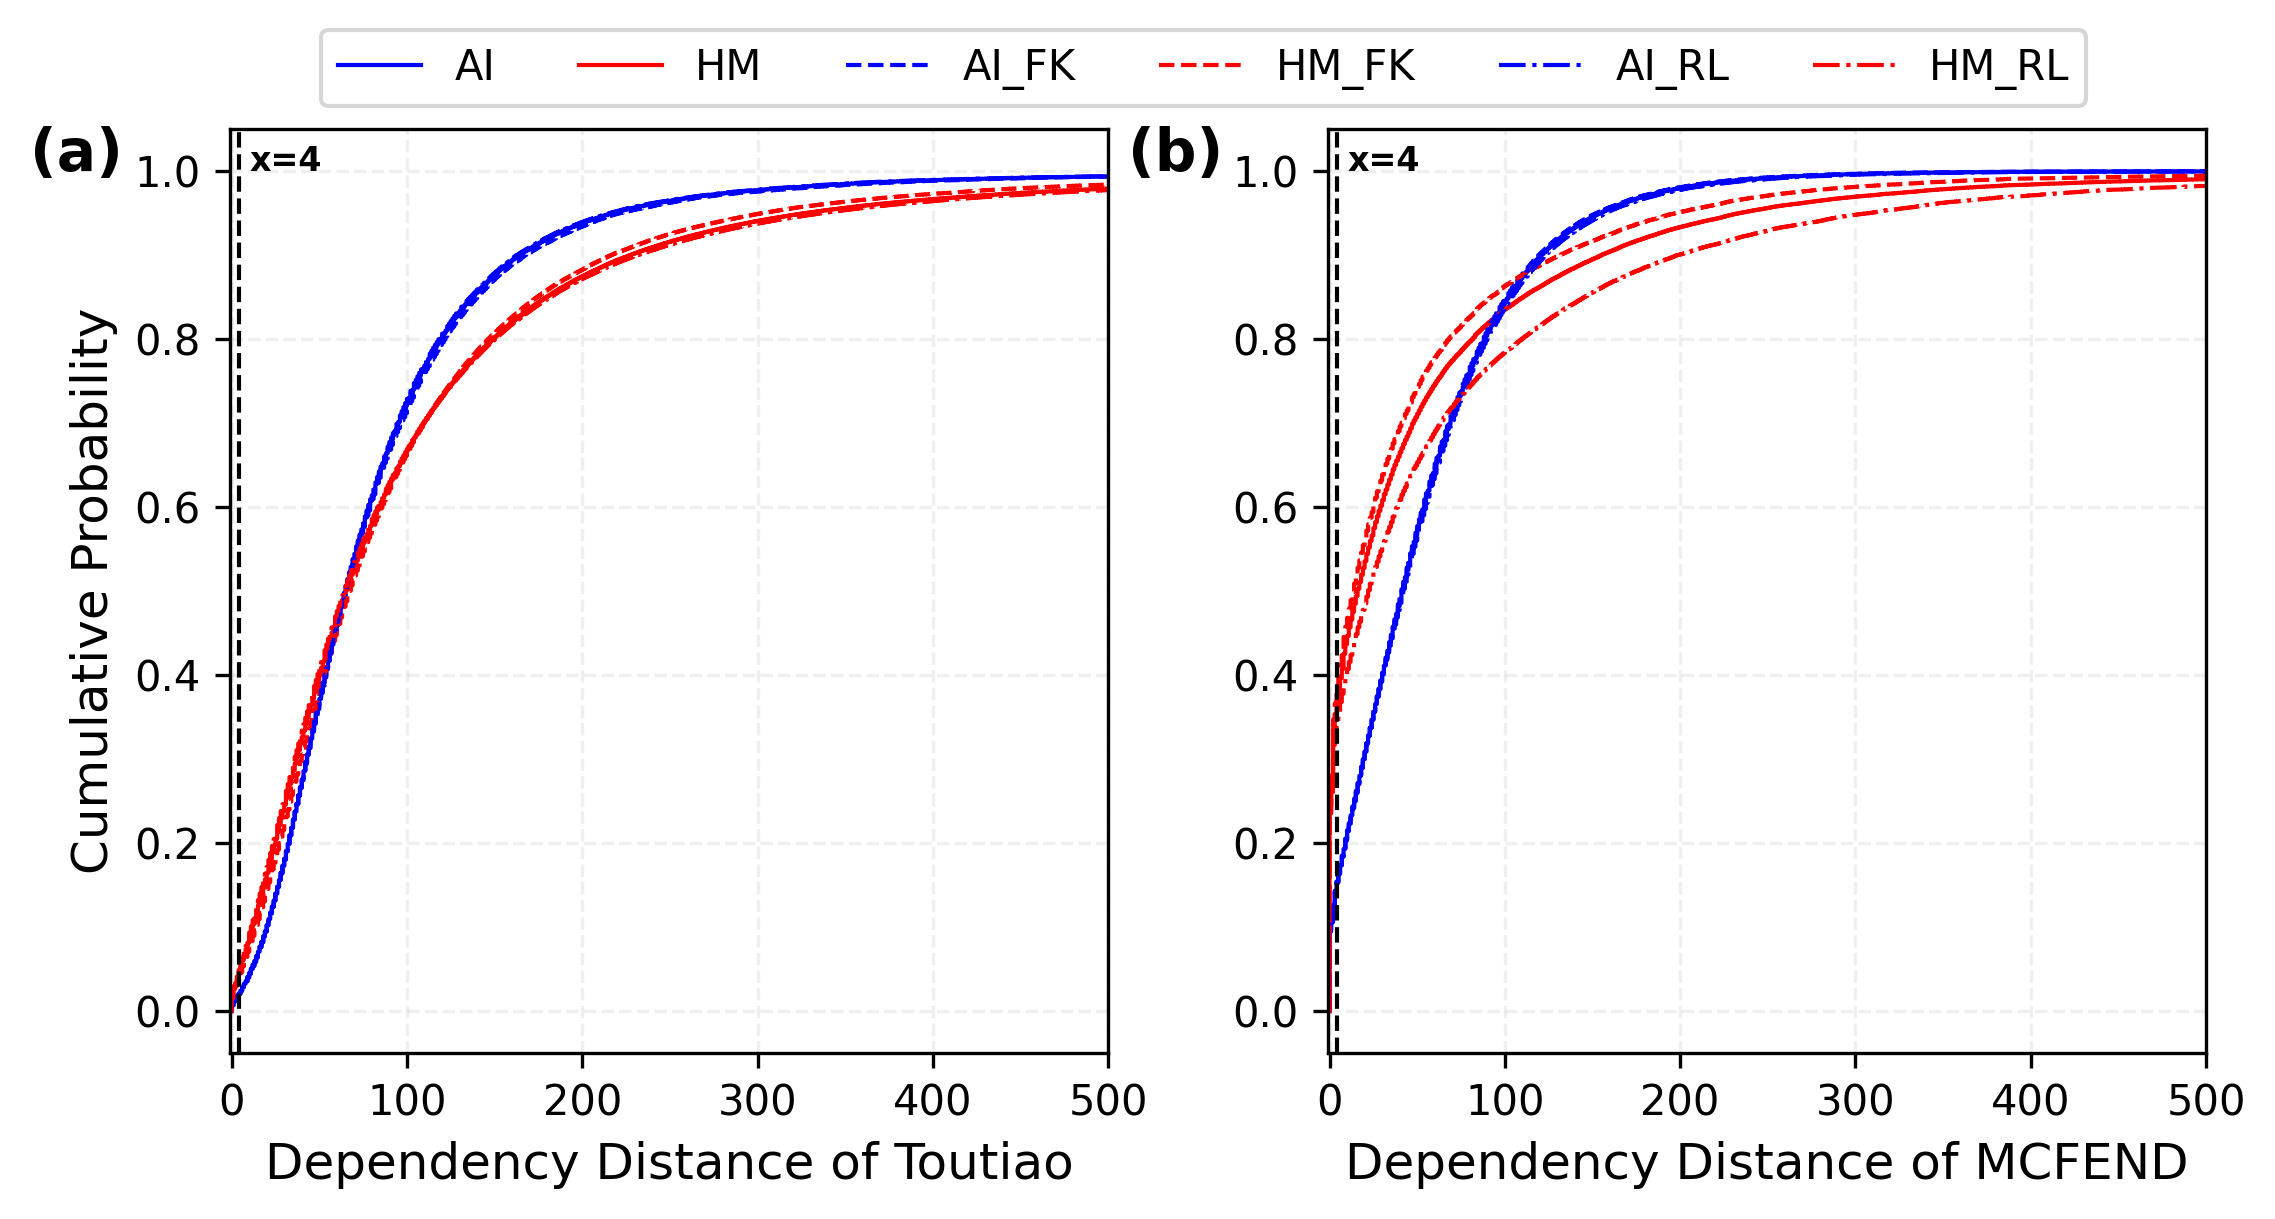

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# For ease of review, limited data are presented here.
# For ease of review, limited data are presented here.
# For ease of review, limited data are presented here.

hanlp_MCFNED_lists = pd.read_csv('hanlp_MCFEND_lists.csv')
hanlp_data_lists = pd.read_csv('hanlp_data_lists.csv')


def get_all_num(data):
    a = data['dep_DD'].apply(ast.literal_eval)
    all_numbers = [num for sublist in a for num in sublist]
    return all_numbers

fig, axes = plt.subplots(1, 2, figsize=(8.5, 4), dpi=300)

sorted_data = np.sort(np.array(get_all_num(hanlp_data_lists[hanlp_data_lists['MY_AI']==1])))
cdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
axes[0].plot(sorted_data, cdf, label='AI', color='blue',lw=1)
sorted_data = np.sort(np.array(get_all_num(hanlp_data_lists[hanlp_data_lists['MY_AI']==0])))
cdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
axes[0].plot(sorted_data, cdf, label='HM', color='red',lw=1)

sorted_data = np.sort(np.array(get_all_num(hanlp_data_lists[(hanlp_data_lists['MY_AI']==1)&(hanlp_data_lists['MY_FK']==1)])))
cdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
axes[0].plot(sorted_data, cdf, label='AI_FK', linestyle='--', color='blue',lw=1)

sorted_data = np.sort(np.array(get_all_num(hanlp_data_lists[(hanlp_data_lists['MY_AI']==0)&(hanlp_data_lists['MY_FK']==1)])))
cdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
axes[0].plot(sorted_data, cdf, label='HM_FK', linestyle='--', color='red',lw=1)

sorted_data = np.sort(np.array(get_all_num(hanlp_data_lists[(hanlp_data_lists['MY_AI']==1)&(hanlp_data_lists['MY_FK']==0)])))
cdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
axes[0].plot(sorted_data, cdf, label='AI_RL', linestyle='-.', color='blue',lw=1)

sorted_data = np.sort(np.array(get_all_num(hanlp_data_lists[(hanlp_data_lists['MY_AI']==0)&(hanlp_data_lists['MY_FK']==0)])))
cdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
axes[0].plot(sorted_data, cdf, label='HM_RL', linestyle='-.', color='red',lw=1)
axes[0].axvline(x=4, color='k', linestyle='--', linewidth=1)
axes[0].set_xlim([-1, 500])
axes[0].grid(alpha=0.2, linestyle='--')
axes[0].text(10, 1, 'x=4', fontsize=8, fontweight='bold')
axes[0].set_xlabel('Dependency Distance of Toutiao', fontsize=12)
axes[0].set_ylabel('Cumulative Probability', fontsize=12)

sorted_data = np.sort(np.array(get_all_num(hanlp_MCFNED_lists[hanlp_MCFNED_lists['MY_AI']==1])))
cdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
axes[1].plot(sorted_data, cdf, label='AI', color='blue',lw=1)
sorted_data = np.sort(np.array(get_all_num(hanlp_MCFNED_lists[hanlp_MCFNED_lists['MY_AI']==0])))
cdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
axes[1].plot(sorted_data, cdf, label='HM', color='red',lw=1)

sorted_data = np.sort(np.array(get_all_num(hanlp_MCFNED_lists[(hanlp_MCFNED_lists['MY_AI']==1)&(hanlp_MCFNED_lists['MY_FK']==1)])))
cdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
axes[1].plot(sorted_data, cdf, label='AI_FK', linestyle='--', color='blue',lw=1)

sorted_data = np.sort(np.array(get_all_num(hanlp_MCFNED_lists[(hanlp_MCFNED_lists['MY_AI']==0)&(hanlp_MCFNED_lists['MY_FK']==1)])))
cdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
axes[1].plot(sorted_data, cdf, label='HM_FK', linestyle='--', color='red',lw=1)

sorted_data = np.sort(np.array(get_all_num(hanlp_MCFNED_lists[(hanlp_MCFNED_lists['MY_AI']==1)&(hanlp_MCFNED_lists['MY_FK']==0)])))
cdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
axes[1].plot(sorted_data, cdf, label='AI_RL', linestyle='-.', color='blue',lw=1)

sorted_data = np.sort(np.array(get_all_num(hanlp_MCFNED_lists[(hanlp_MCFNED_lists['MY_AI']==0)&(hanlp_MCFNED_lists['MY_FK']==0)])))
cdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
axes[1].plot(sorted_data, cdf, label='HM_RL', linestyle='-.', color='red',lw=1)
axes[1].axvline(x=4, color='k', linestyle='--', linewidth=1)
axes[1].set_xlim([-1, 500])
axes[1].grid(alpha=0.2, linestyle='--')
axes[1].text(10, 1, 'x=4', fontsize=8, fontweight='bold')
axes[1].set_xlabel('Dependency Distance of MCFEND', fontsize=12)

axes[0].legend(loc='upper left', ncol = 6, bbox_to_anchor=(0.08, 1.13))

axes[0].text(-115, 1, '(a)', fontsize=14, fontweight='bold')
axes[1].text(-115, 1, '(b)', fontsize=14, fontweight='bold')
plt.subplots_adjust(wspace=0.25)

# plt.savefig("fig/DD_CDF.jpg", dpi=300)
# plt.savefig("fig/DD_CDF.svg", dpi=300)
plt.savefig("fig/DD_CDF.eps", dpi=300)
# plt.savefig("fig/DD_CDF.pdf", dpi=300)
plt.show()


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


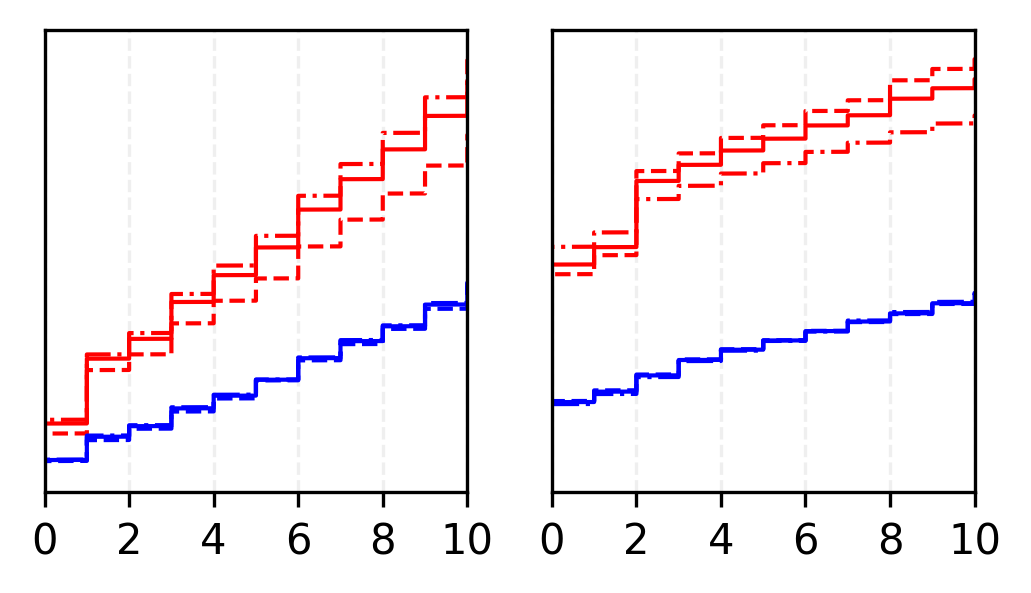

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 2, figsize=(4, 2), dpi=300)

sorted_data = np.sort(np.array(get_all_num(hanlp_data_lists[hanlp_data_lists['MY_AI']==1])))
cdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
axes[0].plot(sorted_data, cdf, label='AI', color='blue',lw=1)

sorted_data = np.sort(np.array(get_all_num(hanlp_data_lists[hanlp_data_lists['MY_AI']==0])))
cdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
axes[0].plot(sorted_data, cdf, label='HM', color='red',lw=1)

sorted_data = np.sort(np.array(get_all_num(hanlp_data_lists[(hanlp_data_lists['MY_AI']==1)&(hanlp_data_lists['MY_FK']==1)])))
cdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
axes[0].plot(sorted_data, cdf, label='AI_FK', linestyle='--', color='blue',lw=1)

sorted_data = np.sort(np.array(get_all_num(hanlp_data_lists[(hanlp_data_lists['MY_AI']==0)&(hanlp_data_lists['MY_FK']==1)])))
cdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
axes[0].plot(sorted_data, cdf, label='HM_FK', linestyle='--', color='red',lw=1)

sorted_data = np.sort(np.array(get_all_num(hanlp_data_lists[(hanlp_data_lists['MY_AI']==1)&(hanlp_data_lists['MY_FK']==0)])))
cdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
axes[0].plot(sorted_data, cdf, label='AI_RL', linestyle='-.', color='blue',lw=1)

sorted_data = np.sort(np.array(get_all_num(hanlp_data_lists[(hanlp_data_lists['MY_AI']==0)&(hanlp_data_lists['MY_FK']==0)])))
cdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
axes[0].plot(sorted_data, cdf, label='HM_RL', linestyle='-.', color='red',lw=1)
axes[0].grid(alpha=0.2, linestyle='--')

sorted_data = np.sort(np.array(get_all_num(hanlp_MCFNED_lists[hanlp_MCFNED_lists['MY_AI']==1])))
cdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
axes[1].plot(sorted_data, cdf, label='AI', color='blue',lw=1)

sorted_data = np.sort(np.array(get_all_num(hanlp_MCFNED_lists[hanlp_MCFNED_lists['MY_AI']==0])))
cdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
axes[1].plot(sorted_data, cdf, label='HM', color='red',lw=1)

sorted_data = np.sort(np.array(get_all_num(hanlp_MCFNED_lists[(hanlp_MCFNED_lists['MY_AI']==1)&(hanlp_MCFNED_lists['MY_FK']==1)])))
cdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
axes[1].plot(sorted_data, cdf, label='AI_FK', linestyle='--', color='blue',lw=1)

sorted_data = np.sort(np.array(get_all_num(hanlp_MCFNED_lists[(hanlp_MCFNED_lists['MY_AI']==0)&(hanlp_MCFNED_lists['MY_FK']==1)])))
cdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
axes[1].plot(sorted_data, cdf, label='HM_FK', linestyle='--', color='red',lw=1)

sorted_data = np.sort(np.array(get_all_num(hanlp_MCFNED_lists[(hanlp_MCFNED_lists['MY_AI']==1)&(hanlp_MCFNED_lists['MY_FK']==0)])))
cdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
axes[1].plot(sorted_data, cdf, label='AI_RL', linestyle='-.', color='blue',lw=1)

sorted_data = np.sort(np.array(get_all_num(hanlp_MCFNED_lists[(hanlp_MCFNED_lists['MY_AI']==0)&(hanlp_MCFNED_lists['MY_FK']==0)])))
cdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
axes[1].plot(sorted_data, cdf, label='HM_RL', linestyle='-.', color='red',lw=1)
axes[1].grid(alpha=0.2, linestyle='--')

axes[0].set_yticks([])
axes[1].set_yticks([])

axes[0].set_xticks(np.arange(0, 11, 2))
axes[0].set_xlim(0, 10)
axes[0].set_ylim(0, 0.1)

axes[1].set_xticks(np.arange(0, 11, 2))
axes[1].set_xlim(0, 10)
axes[1].set_ylim(0, 0.5)

plt.savefig("fig/DD_CDF_sub1.eps", dpi=300)
plt.show()


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


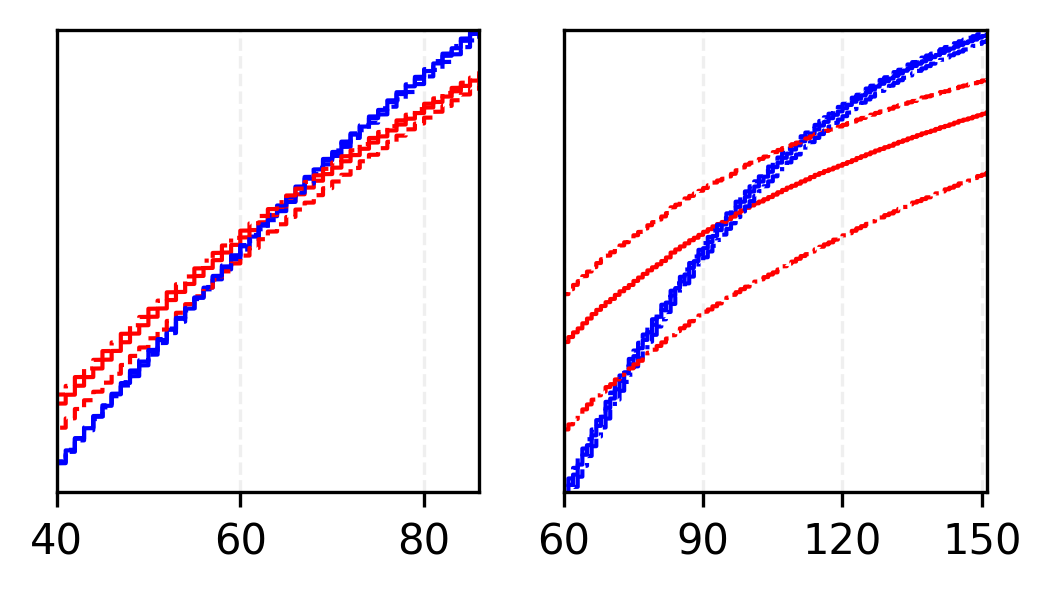

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 2, figsize=(4, 2), dpi=300)

sorted_data = np.sort(np.array(get_all_num(hanlp_data_lists[hanlp_data_lists['MY_AI']==1])))
cdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
axes[0].plot(sorted_data, cdf, label='AI', color='blue',lw=1)

sorted_data = np.sort(np.array(get_all_num(hanlp_data_lists[hanlp_data_lists['MY_AI']==0])))
cdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
axes[0].plot(sorted_data, cdf, label='HM', color='red',lw=1)

sorted_data = np.sort(np.array(get_all_num(hanlp_data_lists[(hanlp_data_lists['MY_AI']==1)&(hanlp_data_lists['MY_FK']==1)])))
cdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
axes[0].plot(sorted_data, cdf, label='AI_FK', linestyle='--', color='blue',lw=1)

sorted_data = np.sort(np.array(get_all_num(hanlp_data_lists[(hanlp_data_lists['MY_AI']==0)&(hanlp_data_lists['MY_FK']==1)])))
cdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
axes[0].plot(sorted_data, cdf, label='HM_FK', linestyle='--', color='red',lw=1)

sorted_data = np.sort(np.array(get_all_num(hanlp_data_lists[(hanlp_data_lists['MY_AI']==1)&(hanlp_data_lists['MY_FK']==0)])))
cdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
axes[0].plot(sorted_data, cdf, label='AI_RL', linestyle='-.', color='blue',lw=1)

sorted_data = np.sort(np.array(get_all_num(hanlp_data_lists[(hanlp_data_lists['MY_AI']==0)&(hanlp_data_lists['MY_FK']==0)])))
cdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
axes[0].plot(sorted_data, cdf, label='HM_RL', linestyle='-.', color='red',lw=1)
axes[0].grid(alpha=0.2, linestyle='--')

sorted_data = np.sort(np.array(get_all_num(hanlp_MCFNED_lists[hanlp_MCFNED_lists['MY_AI']==1])))
cdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
axes[1].plot(sorted_data, cdf, label='AI', color='blue',lw=1)

sorted_data = np.sort(np.array(get_all_num(hanlp_MCFNED_lists[hanlp_MCFNED_lists['MY_AI']==0])))
cdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
axes[1].plot(sorted_data, cdf, label='HM', color='red',lw=1)

sorted_data = np.sort(np.array(get_all_num(hanlp_MCFNED_lists[(hanlp_MCFNED_lists['MY_AI']==1)&(hanlp_MCFNED_lists['MY_FK']==1)])))
cdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
axes[1].plot(sorted_data, cdf, label='AI_FK', linestyle='--', color='blue',lw=1)

sorted_data = np.sort(np.array(get_all_num(hanlp_MCFNED_lists[(hanlp_MCFNED_lists['MY_AI']==0)&(hanlp_MCFNED_lists['MY_FK']==1)])))
cdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
axes[1].plot(sorted_data, cdf, label='HM_FK', linestyle='--', color='red',lw=1)

sorted_data = np.sort(np.array(get_all_num(hanlp_MCFNED_lists[(hanlp_MCFNED_lists['MY_AI']==1)&(hanlp_MCFNED_lists['MY_FK']==0)])))
cdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
axes[1].plot(sorted_data, cdf, label='AI_RL', linestyle='-.', color='blue',lw=1)

sorted_data = np.sort(np.array(get_all_num(hanlp_MCFNED_lists[(hanlp_MCFNED_lists['MY_AI']==0)&(hanlp_MCFNED_lists['MY_FK']==0)])))
cdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
axes[1].plot(sorted_data, cdf, label='HM_RL', linestyle='-.', color='red',lw=1)
axes[1].grid(alpha=0.2, linestyle='--')

axes[0].set_yticks([])
axes[1].set_yticks([])

axes[0].set_xticks(np.arange(40, 85, 20))
axes[0].set_xlim(40, 86)
axes[0].set_ylim(0.25, 0.65)

axes[1].set_xticks(np.arange(60, 151, 30))
axes[1].set_xlim(60, 151)
axes[1].set_ylim(0.65, 0.95)

plt.savefig("fig/DD_CDF_sub2.eps", dpi=300)
plt.show()


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


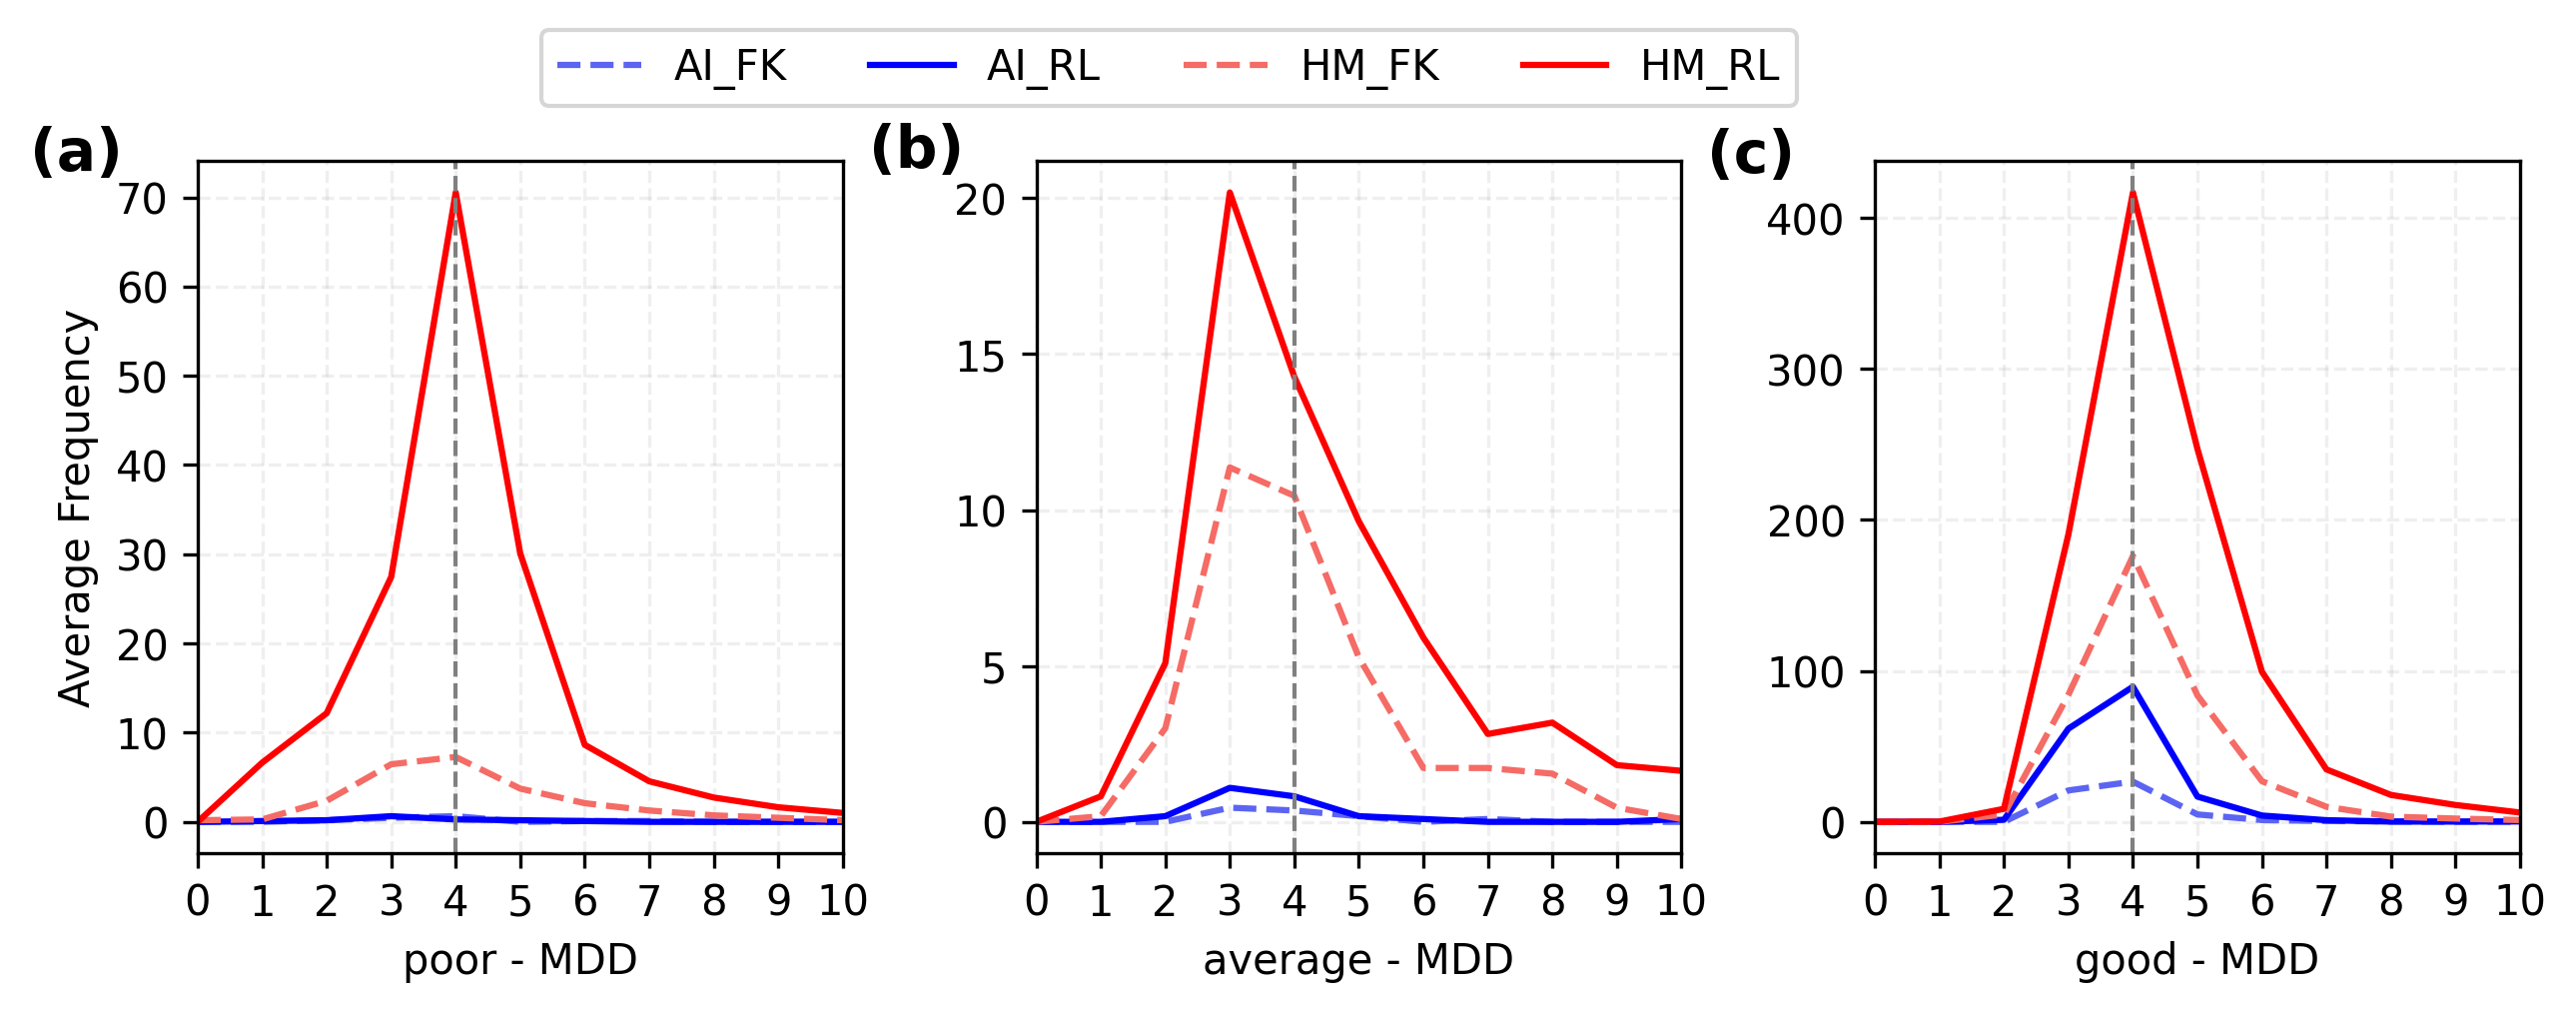

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# data = pd.DataFrame({
#     'values': [1.2, 3.7, 5.0, 88.4, 99.9, 45.3, 2.1, 100.5, 0.9, 50.0]
# })
hanlp_data_lists = pd.read_csv('hanlp_data_lists.csv')

max_ = 11
# data['rounded'] = data['values'].round().astype(int)
fig, axes = plt.subplots(1, 3, figsize=(10, 3), dpi=300)

quality_order = ['poor', 'average', 'good']
counts_ai_fk = hanlp_data_lists[(hanlp_data_lists['content_quality_finally']=='poor')&(hanlp_data_lists['MY_AI']==1)&(hanlp_data_lists['MY_FK']==1)]['dep_MDD'].round().astype(int).value_counts().reindex(range(max_), fill_value=0).sort_index()
counts_ai_rl = hanlp_data_lists[(hanlp_data_lists['content_quality_finally']=='poor')&(hanlp_data_lists['MY_AI']==1)&(hanlp_data_lists['MY_FK']==0)]['dep_MDD'].round().astype(int).value_counts().reindex(range(max_), fill_value=0).sort_index()
counts_hm_fk = hanlp_data_lists[(hanlp_data_lists['content_quality_finally']=='poor')&(hanlp_data_lists['MY_AI']==0)&(hanlp_data_lists['MY_FK']==1)]['dep_MDD'].round().astype(int).value_counts().reindex(range(max_), fill_value=0).sort_index()
counts_hm_rl = hanlp_data_lists[(hanlp_data_lists['content_quality_finally']=='poor')&(hanlp_data_lists['MY_AI']==0)&(hanlp_data_lists['MY_FK']==0)]['dep_MDD'].round().astype(int).value_counts().reindex(range(max_), fill_value=0).sort_index()

axes[0].plot(counts_ai_fk.index, counts_ai_fk.values/len(counts_ai_fk), label='AI_FK',color='#5C64F2', linestyle='--')
axes[0].plot(counts_ai_rl.index, counts_ai_rl.values/len(counts_ai_rl), label='AI_RL',color='blue', linestyle='-')
axes[0].plot(counts_hm_fk.index, counts_hm_fk.values/len(counts_hm_fk), label='HM_FK',color='#F56B65', linestyle='--')
axes[0].plot(counts_hm_rl.index, counts_hm_rl.values/len(counts_hm_rl), label='HM_RL',color='red', linestyle='-')

axes[0].axvline(x=4, color='gray', linestyle='--', linewidth=1)
axes[0].set_xlabel('poor - MDD')
axes[0].set_ylabel('Average Frequency')
#axes[0].legend(fontsize=7, markerscale=3)
axes[0].grid(alpha=0.2, linestyle='--')
#axes[2].set_title('Log Transformation (MY_FK = 0)')
axes[0].set_xlim([0, 10])  
#axes[0].set_ylim([0, 10])  
axes[0].set_xticks(np.arange(0,11, 1))



counts_ai_fk = hanlp_data_lists[(hanlp_data_lists['content_quality_finally']=='average')&(hanlp_data_lists['MY_AI']==1)&(hanlp_data_lists['MY_FK']==1)]['dep_MDD'].round().astype(int).value_counts().reindex(range(max_), fill_value=0).sort_index()
counts_ai_rl = hanlp_data_lists[(hanlp_data_lists['content_quality_finally']=='average')&(hanlp_data_lists['MY_AI']==1)&(hanlp_data_lists['MY_FK']==0)]['dep_MDD'].round().astype(int).value_counts().reindex(range(max_), fill_value=0).sort_index()
counts_hm_fk = hanlp_data_lists[(hanlp_data_lists['content_quality_finally']=='average')&(hanlp_data_lists['MY_AI']==0)&(hanlp_data_lists['MY_FK']==1)]['dep_MDD'].round().astype(int).value_counts().reindex(range(max_), fill_value=0).sort_index()
counts_hm_rl = hanlp_data_lists[(hanlp_data_lists['content_quality_finally']=='average')&(hanlp_data_lists['MY_AI']==0)&(hanlp_data_lists['MY_FK']==0)]['dep_MDD'].round().astype(int).value_counts().reindex(range(max_), fill_value=0).sort_index()
axes[1].plot(counts_ai_fk.index, counts_ai_fk.values/len(counts_ai_fk), label='AI_FK',color='#5C64F2', linestyle='--')
axes[1].plot(counts_ai_rl.index, counts_ai_rl.values/len(counts_ai_rl), label='AI_RL',color='blue', linestyle='-')
axes[1].plot(counts_hm_fk.index, counts_hm_fk.values/len(counts_hm_fk), label='HM_FK',color='#F56B65', linestyle='--')
axes[1].plot(counts_hm_rl.index, counts_hm_rl.values/len(counts_hm_rl), label='HM_RL',color='red', linestyle='-')
axes[1].axvline(x=4, color='gray', linestyle='--', linewidth=1)
axes[1].grid(alpha=0.2, linestyle='--')
axes[1].set_xlabel('average - MDD')
axes[1].set_xlim([0, 10]) 
axes[1].set_xticks(np.arange(0,11, 1))


counts_ai_fk = hanlp_data_lists[(hanlp_data_lists['content_quality_finally']=='good')&(hanlp_data_lists['MY_AI']==1)&(hanlp_data_lists['MY_FK']==1)]['dep_MDD'].round().astype(int).value_counts().reindex(range(max_), fill_value=0).sort_index()
counts_ai_rl = hanlp_data_lists[(hanlp_data_lists['content_quality_finally']=='good')&(hanlp_data_lists['MY_AI']==1)&(hanlp_data_lists['MY_FK']==0)]['dep_MDD'].round().astype(int).value_counts().reindex(range(max_), fill_value=0).sort_index()
counts_hm_fk = hanlp_data_lists[(hanlp_data_lists['content_quality_finally']=='good')&(hanlp_data_lists['MY_AI']==0)&(hanlp_data_lists['MY_FK']==1)]['dep_MDD'].round().astype(int).value_counts().reindex(range(max_), fill_value=0).sort_index()
counts_hm_rl = hanlp_data_lists[(hanlp_data_lists['content_quality_finally']=='good')&(hanlp_data_lists['MY_AI']==0)&(hanlp_data_lists['MY_FK']==0)]['dep_MDD'].round().astype(int).value_counts().reindex(range(max_), fill_value=0).sort_index()
axes[2].plot(counts_ai_fk.index, counts_ai_fk.values/len(counts_ai_fk), label='AI_FK',color='#5C64F2', linestyle='--')
axes[2].plot(counts_ai_rl.index, counts_ai_rl.values/len(counts_ai_rl), label='AI_RL',color='blue', linestyle='-')
axes[2].plot(counts_hm_fk.index, counts_hm_fk.values/len(counts_hm_fk), label='HM_FK',color='#F56B65', linestyle='--')
axes[2].plot(counts_hm_rl.index, counts_hm_rl.values/len(counts_hm_rl), label='HM_RL',color='red', linestyle='-')
axes[2].axvline(x=4, color='gray', linestyle='--', linewidth=1)
axes[2].grid(alpha=0.2, linestyle='--')
axes[2].set_xlabel('good - MDD')
axes[2].set_xlim([0, 10])  
axes[2].set_xticks(np.arange(0,11, 1))

#plt.title('Frequency Distribution of Rounded Values (0-100)')
#plt.xlabel('MDD')
#plt.ylabel('Frequency')
axes[0].legend(loc='upper left', ncol = 4, bbox_to_anchor=(0.5, 1.22))
#plt.tight_layout()

axes[0].text(-2.6, 73, '(a)', fontsize=14, fontweight='bold')
axes[1].text(-2.6, 21, '(b)', fontsize=14, fontweight='bold')
axes[2].text(-2.6, 430, '(c)', fontsize=14, fontweight='bold')

plt.subplots_adjust(wspace=0.3)

# plt.savefig("fig/MDD_Toutia.jpg", dpi=300)
# plt.savefig("fig/MDD_Toutia.svg", dpi=300)
plt.savefig("fig/MDD_Toutia.eps", dpi=300)
plt.savefig("fig/MDD_Toutia.pdf", dpi=300)


plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


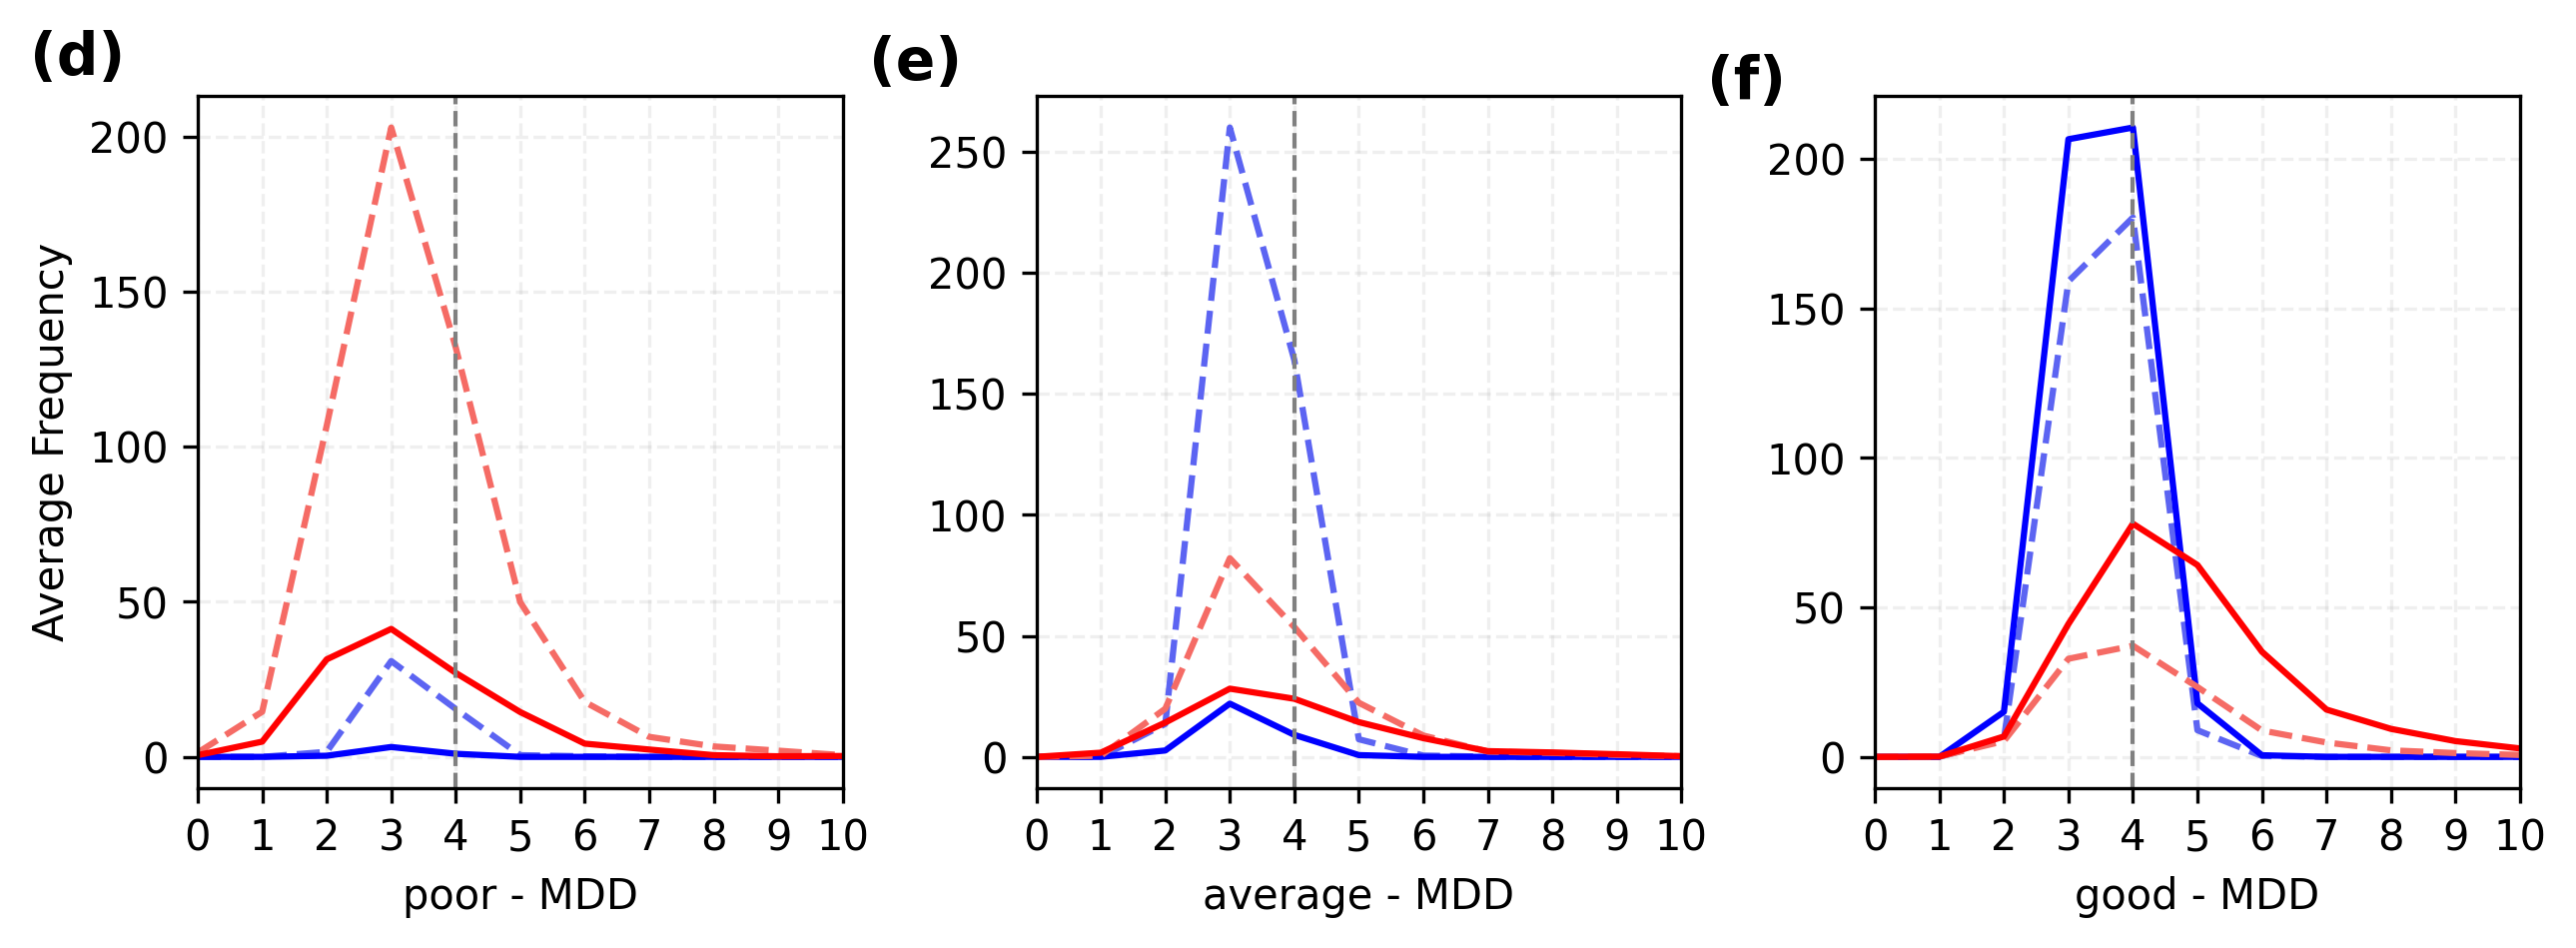

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

hanlp_data_lists = pd.read_csv('hanlp_MCFEND_lists.csv')

max_ = 11
fig, axes = plt.subplots(1, 3, figsize=(10, 3), dpi=300)

quality_order = ['poor', 'average', 'good']

counts_ai_fk = hanlp_data_lists[(hanlp_data_lists['content_quality_finally']=='poor')&(hanlp_data_lists['MY_AI']==1)&(hanlp_data_lists['MY_FK']==1)]['dep_MDD'].round().astype(int).value_counts().reindex(range(max_), fill_value=0).sort_index()
counts_ai_rl = hanlp_data_lists[(hanlp_data_lists['content_quality_finally']=='poor')&(hanlp_data_lists['MY_AI']==1)&(hanlp_data_lists['MY_FK']==0)]['dep_MDD'].round().astype(int).value_counts().reindex(range(max_), fill_value=0).sort_index()
counts_hm_fk = hanlp_data_lists[(hanlp_data_lists['content_quality_finally']=='poor')&(hanlp_data_lists['MY_AI']==0)&(hanlp_data_lists['MY_FK']==1)]['dep_MDD'].round().astype(int).value_counts().reindex(range(max_), fill_value=0).sort_index()
counts_hm_rl = hanlp_data_lists[(hanlp_data_lists['content_quality_finally']=='poor')&(hanlp_data_lists['MY_AI']==0)&(hanlp_data_lists['MY_FK']==0)]['dep_MDD'].round().astype(int).value_counts().reindex(range(max_), fill_value=0).sort_index()

axes[0].plot(counts_ai_fk.index, counts_ai_fk.values/len(counts_ai_fk), label='AI_FK',color='#5C64F2', linestyle='--')
axes[0].plot(counts_ai_rl.index, counts_ai_rl.values/len(counts_ai_rl), label='AI_RL',color='blue', linestyle='-')
axes[0].plot(counts_hm_fk.index, counts_hm_fk.values/len(counts_hm_fk), label='HM_FK',color='#F56B65', linestyle='--')
axes[0].plot(counts_hm_rl.index, counts_hm_rl.values/len(counts_hm_rl), label='HM_RL',color='red', linestyle='-')
axes[0].axvline(x=4, color='gray', linestyle='--', linewidth=1)
axes[0].set_xlabel('poor - MDD')
axes[0].set_ylabel('Average Frequency')
axes[0].grid(alpha=0.2, linestyle='--')
axes[0].set_xlim([0, 10])
axes[0].set_xticks(np.arange(0,11, 1))

counts_ai_fk = hanlp_data_lists[(hanlp_data_lists['content_quality_finally']=='average')&(hanlp_data_lists['MY_AI']==1)&(hanlp_data_lists['MY_FK']==1)]['dep_MDD'].round().astype(int).value_counts().reindex(range(max_), fill_value=0).sort_index()
counts_ai_rl = hanlp_data_lists[(hanlp_data_lists['content_quality_finally']=='average')&(hanlp_data_lists['MY_AI']==1)&(hanlp_data_lists['MY_FK']==0)]['dep_MDD'].round().astype(int).value_counts().reindex(range(max_), fill_value=0).sort_index()
counts_hm_fk = hanlp_data_lists[(hanlp_data_lists['content_quality_finally']=='average')&(hanlp_data_lists['MY_AI']==0)&(hanlp_data_lists['MY_FK']==1)]['dep_MDD'].round().astype(int).value_counts().reindex(range(max_), fill_value=0).sort_index()
counts_hm_rl = hanlp_data_lists[(hanlp_data_lists['content_quality_finally']=='average')&(hanlp_data_lists['MY_AI']==0)&(hanlp_data_lists['MY_FK']==0)]['dep_MDD'].round().astype(int).value_counts().reindex(range(max_), fill_value=0).sort_index()

axes[1].plot(counts_ai_fk.index, counts_ai_fk.values/len(counts_ai_fk), label='AI_FK',color='#5C64F2', linestyle='--')
axes[1].plot(counts_ai_rl.index, counts_ai_rl.values/len(counts_ai_rl), label='AI_RL',color='blue', linestyle='-')
axes[1].plot(counts_hm_fk.index, counts_hm_fk.values/len(counts_hm_fk), label='HM_FK',color='#F56B65', linestyle='--')
axes[1].plot(counts_hm_rl.index, counts_hm_rl.values/len(counts_hm_rl), label='HM_RL',color='red', linestyle='-')
axes[1].axvline(x=4, color='gray', linestyle='--', linewidth=1)
axes[1].grid(alpha=0.2, linestyle='--')
axes[1].set_xlabel('average - MDD')
axes[1].set_xlim([0, 10])
axes[1].set_xticks(np.arange(0,11, 1))

counts_ai_fk = hanlp_data_lists[(hanlp_data_lists['content_quality_finally']=='good')&(hanlp_data_lists['MY_AI']==1)&(hanlp_data_lists['MY_FK']==1)]['dep_MDD'].round().astype(int).value_counts().reindex(range(max_), fill_value=0).sort_index()
counts_ai_rl = hanlp_data_lists[(hanlp_data_lists['content_quality_finally']=='good')&(hanlp_data_lists['MY_AI']==1)&(hanlp_data_lists['MY_FK']==0)]['dep_MDD'].round().astype(int).value_counts().reindex(range(max_), fill_value=0).sort_index()
counts_hm_fk = hanlp_data_lists[(hanlp_data_lists['content_quality_finally']=='good')&(hanlp_data_lists['MY_AI']==0)&(hanlp_data_lists['MY_FK']==1)]['dep_MDD'].round().astype(int).value_counts().reindex(range(max_), fill_value=0).sort_index()
counts_hm_rl = hanlp_data_lists[(hanlp_data_lists['content_quality_finally']=='good')&(hanlp_data_lists['MY_AI']==0)&(hanlp_data_lists['MY_FK']==0)]['dep_MDD'].round().astype(int).value_counts().reindex(range(max_), fill_value=0).sort_index()

axes[2].plot(counts_ai_fk.index, counts_ai_fk.values/len(counts_ai_fk), label='AI_FK',color='#5C64F2', linestyle='--')
axes[2].plot(counts_ai_rl.index, counts_ai_rl.values/len(counts_ai_rl), label='AI_RL',color='blue', linestyle='-')
axes[2].plot(counts_hm_fk.index, counts_hm_fk.values/len(counts_hm_fk), label='HM_FK',color='#F56B65', linestyle='--')
axes[2].plot(counts_hm_rl.index, counts_hm_rl.values/len(counts_hm_rl), label='HM_RL',color='red', linestyle='-')
axes[2].axvline(x=4, color='gray', linestyle='--', linewidth=1)
axes[2].grid(alpha=0.2, linestyle='--')
axes[2].set_xlabel('good - MDD')
axes[2].set_xlim([0, 10])
axes[2].set_xticks(np.arange(0,11, 1))

axes[0].text(-2.6, 220, '(d)', fontsize=14, fontweight='bold')
axes[1].text(-2.6, 280, '(e)', fontsize=14, fontweight='bold')
axes[2].text(-2.6, 220, '(f)', fontsize=14, fontweight='bold')

plt.subplots_adjust(wspace=0.3)

# plt.savefig("fig/MDD_MCFEND.jpg", dpi=300)
# plt.savefig("fig/MDD_MCFEND.svg", dpi=300)
plt.savefig("fig/MDD_MCFEND.eps", dpi=300)
# plt.savefig("fig/MDD_MCFEND.pdf", dpi=300)

plt.show()


# Fig. 10 & Fig. 11

In [31]:
import pandas as pd
import ast
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import FormatStrFormatter  

np.random.seed(2025)


# Two files are about 1.13GB, and for ease of review, it is not run here.
# Two files are about 1.13GB, and for ease of review, it is not run here.
# Two files are about 1.13GB, and for ease of review, it is not run here.
hanlp_data = pd.read_csv('hanlp_data.csv')
hanlp_data_MCFNED = pd.read_csv('hanlp_MCFEND.csv')

#hanlp_data_lists = pd.read_csv('hanlp_data_lists.csv')
#hanlp_data_MCFNED_lists = pd.read_csv('hanlp_MCFEND_lists.csv')


In [29]:
def get_pos_n_grams(data,ai,fk,Q_name,Q=None,n = 2,topk = 5):
    if Q==None:
        linshi = []
        length  = len(data[(data['MY_AI']==ai)&(data['MY_FK']==fk)]['pos'].index.to_list())
        for i in data[(data['MY_AI']==ai)&(data['MY_FK']==fk)]['pos'].index.to_list():
            linshi.extend(ast.literal_eval(data[(data['MY_AI']==ai)&(data['MY_FK']==fk)]['pos'][i]))
    else:
        linshi = []
        length = len(data[(data[Q_name]==Q)&(data['MY_AI']==ai)&(data['MY_FK']==fk)]['pos'].index.to_list())
        for i in data[(data[Q_name]==Q)&(data['MY_AI']==ai)&(data['MY_FK']==fk)]['pos'].index.to_list():
            linshi.extend(ast.literal_eval(data[(data['MY_AI']==ai)&(data['MY_FK']==fk)]['pos'][i]))

    pos_texts = [' '.join(pos) for pos in linshi]
    vectorizer = CountVectorizer(analyzer='word', 
                                ngram_range=(n, n),
                                token_pattern=r'\b\w+\b',
                                min_df=2)
    X = vectorizer.fit_transform(pos_texts)
    df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
    top_features = df.sum().sort_values(ascending=False).head(5)
    return top_features, length

In [ ]:
Q_names = 'content_quality_finally'
#hanlp_data = pd.read_csv('hanlp_data.csv')

poor_ai_fk,poor_length_a = get_pos_n_grams(hanlp_data,ai=1,fk=1,Q_name=Q_names,Q='poor',n = 2,topk = 5)
poor_ai_rl,poor_length_b = get_pos_n_grams(hanlp_data,ai=1,fk=0,Q_name=Q_names,Q='poor',n = 2,topk = 5)
poor_hm_fk,poor_length_c = get_pos_n_grams(hanlp_data,ai=0,fk=1,Q_name=Q_names,Q='poor',n = 2,topk = 5)
poor_hm_rl,poor_length_d = get_pos_n_grams(hanlp_data,ai=0,fk=0,Q_name=Q_names,Q='poor',n = 2,topk = 5)


average_ai_fk,average_length_a = get_pos_n_grams(hanlp_data,ai=1,fk=1,Q_name=Q_names,Q='average',n = 2,topk = 5)
average_ai_rl,average_length_b  = get_pos_n_grams(hanlp_data,ai=1,fk=0,Q_name=Q_names,Q='average',n = 2,topk = 5)
average_hm_fk,average_length_c  = get_pos_n_grams(hanlp_data,ai=0,fk=1,Q_name=Q_names,Q='average',n = 2,topk = 5)
average_hm_rl,average_length_d  = get_pos_n_grams(hanlp_data,ai=0,fk=0,Q_name=Q_names,Q='average',n = 2,topk = 5)

good_ai_fk,good_length_a = get_pos_n_grams(hanlp_data,ai=1,fk=1,Q_name=Q_names,Q='good',n = 2,topk = 5)
good_ai_rl,good_length_b = get_pos_n_grams(hanlp_data,ai=1,fk=0,Q_name=Q_names,Q='good',n = 2,topk = 5)
good_hm_fk,good_length_c = get_pos_n_grams(hanlp_data,ai=0,fk=1,Q_name=Q_names,Q='good',n = 2,topk = 5)
good_hm_rl,good_length_d = get_pos_n_grams(hanlp_data,ai=0,fk=0,Q_name=Q_names,Q='good',n = 2,topk = 5)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(42)

# 创建 6x4 的子图布局
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(10.5, 7.5),dpi=300)  # figsize 控制整体图像大小
# 遍历所有子图并绘制柱状图
quality_order = ['poor', 'average', 'good']
models = ['AI_FK', 'AI_RL', 'HM_FK', 'HM_AL']
colors1 = ['#F1A48A','#F5B785','#A3CDAA','#A0CADE','#BEC3DF']
colors = ['#E21E2E','#E25B27','#189453','#177BB9','#6563A4']

patterns = ['\\', '//', 'x']
bar_width=0.35

# 绘制柱状图
axes[0,0].bar(poor_ai_fk.index.str.replace(' ','-'), poor_ai_fk.values/poor_length_a,width=bar_width, color=colors1[0])  #,hatch=patterns[0])  # 随机颜色
axes[0,1].bar(poor_ai_rl.index.str.replace(' ','-'), poor_ai_rl.values/poor_length_b,width=bar_width, color=colors1[1])  #,hatch=patterns[0])  # 随机颜色
axes[0,2].bar(poor_hm_fk.index.str.replace(' ','-'), poor_hm_fk.values/poor_length_c,width=bar_width, color=colors1[2])  #,hatch=patterns[0])  # 随机颜色
axes[0,3].bar(poor_hm_rl.index.str.replace(' ','-'), poor_hm_rl.values/poor_length_d,width=bar_width, color=colors1[3])  #,hatch=patterns[0])  # 随机颜色

axes[1,0].bar(average_ai_fk.index.str.replace(' ','-'), average_ai_fk.values/average_length_a,width=bar_width, color=colors[0],alpha=0.65)  #,hatch=patterns[1])  # 随机颜色
axes[1,1].bar(average_ai_rl.index.str.replace(' ','-'), average_ai_rl.values/average_length_b,width=bar_width, color=colors[1],alpha=0.65)  #,hatch=patterns[1])  # 随机颜色
axes[1,2].bar(average_hm_fk.index.str.replace(' ','-'), average_hm_fk.values/average_length_c,width=bar_width, color=colors[2],alpha=0.65)  #,hatch=patterns[1])  # 随机颜色
axes[1,3].bar(average_hm_rl.index.str.replace(' ','-'), average_hm_rl.values/average_length_d,width=bar_width, color=colors[3],alpha=0.65)  #,hatch=patterns[1])  # 随机颜色

axes[2,0].bar(good_ai_fk.index.str.replace(' ','-'), good_ai_fk.values/good_length_a,width=bar_width, color=colors[0],alpha=1)  #,hatch=patterns[2])  # 随机颜色
axes[2,1].bar(good_ai_rl.index.str.replace(' ','-'), good_ai_rl.values/good_length_b,width=bar_width, color=colors[1],alpha=1)  #,hatch=patterns[2])  # 随机颜色
axes[2,2].bar(good_hm_fk.index.str.replace(' ','-'), good_hm_fk.values/good_length_c,width=bar_width, color=colors[2],alpha=1)  #,hatch=patterns[2])  # 随机颜色
axes[2,3].bar(good_hm_rl.index.str.replace(' ','-'), good_hm_rl.values/good_length_d,width=bar_width, color=colors[3],alpha=1)  #,hatch=patterns[2])  # 随机颜色


for i,q in zip([0,1,2],quality_order):
    for j in range(4):
        ax = axes[i, j]
        ax.set_xlabel(q+' - '+models[j],fontsize=12)
        ax.tick_params(axis='x', labelsize=10)
        ax.tick_params(axis='y', labelsize=10)
        ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))


axes[0,0].text(-2.2, 38.5, '(a)', fontsize=14, fontweight='bold')#, transform=axes[0,0].transAxes)#
axes[0,1].text(-2.2, 28.5, '(b)', fontsize=14, fontweight='bold')#)#)#, transform=axes[0,1].transAxes)
axes[0,2].text(-2.2, 21.2, '(c)', fontsize=14, fontweight='bold')#)#, transform=axes[0,2].transAxes)
axes[0,3].text(-2.2, 30.7, '(d)', fontsize=14, fontweight='bold')#, transform=axes[0,3].transAxes)

axes[1,0].text(-2.2, 31.5, '(e)', fontsize=14, fontweight='bold')#, transform=axes[0,0].transAxes)#
axes[1,1].text(-2.2, 24.5, '(f)', fontsize=14, fontweight='bold')#)#)#, transform=axes[0,1].transAxes)
axes[1,2].text(-2.2, 20.3, '(g)', fontsize=14, fontweight='bold')#)#, transform=axes[0,2].transAxes)
axes[1,3].text(-2.2, 18.2, '(h)', fontsize=14, fontweight='bold')#, transform=axes[0,3].transAxes)

axes[2,0].text(-2.2, 50.5, '(i)', fontsize=14, fontweight='bold')#, transform=axes[0,0].transAxes)#
axes[2,1].text(-2.2, 43.5, '(j)', fontsize=14, fontweight='bold')#)#)#, transform=axes[0,1].transAxes)
axes[2,2].text(-2.2, 49.3, '(k)', fontsize=14, fontweight='bold')#)#, transform=axes[0,2].transAxes)
axes[2,3].text(-2.2, 49.1, '(l)', fontsize=14, fontweight='bold')#, transform=axes[0,3].transAxes)

plt.tight_layout()


# plt.savefig("fig/POS_toutiao.jpg", dpi=300)
# plt.savefig("fig/POS_toutiao.svg", dpi=300)
plt.savefig("fig/POS_toutiao.eps", dpi=300)
# plt.savefig("fig/POS_toutiao.pdf", dpi=300)


plt.show()

In [ ]:
Q_names = 'content_quality_finally'
#hanlp_data_MCFNED = pd.read_csv('hanlp_MCFEND.csv')
poor_ai_fk_,poor_length_a_ = get_pos_n_grams(hanlp_data_MCFNED,ai=1,fk=1,Q_name=Q_names,Q='poor',n = 2,topk = 5)
poor_ai_rl_,poor_length_b_ = get_pos_n_grams(hanlp_data_MCFNED,ai=1,fk=0,Q_name=Q_names,Q='poor',n = 2,topk = 5)
poor_hm_fk_,poor_length_c_ = get_pos_n_grams(hanlp_data_MCFNED,ai=0,fk=1,Q_name=Q_names,Q='poor',n = 2,topk = 5)
poor_hm_rl_,poor_length_d_ = get_pos_n_grams(hanlp_data_MCFNED,ai=0,fk=0,Q_name=Q_names,Q='poor',n = 2,topk = 5)


average_ai_fk_,average_length_a_ = get_pos_n_grams(hanlp_data_MCFNED,ai=1,fk=1,Q_name=Q_names,Q='average',n = 2,topk = 5)
average_ai_rl_,average_length_b_  = get_pos_n_grams(hanlp_data_MCFNED,ai=1,fk=0,Q_name=Q_names,Q='average',n = 2,topk = 5)
average_hm_fk_,average_length_c_  = get_pos_n_grams(hanlp_data_MCFNED,ai=0,fk=1,Q_name=Q_names,Q='average',n = 2,topk = 5)
average_hm_rl_,average_length_d_  = get_pos_n_grams(hanlp_data_MCFNED,ai=0,fk=0,Q_name=Q_names,Q='average',n = 2,topk = 5)

good_ai_fk_,good_length_a_ = get_pos_n_grams(hanlp_data_MCFNED,ai=1,fk=1,Q_name=Q_names,Q='good',n = 2,topk = 5)
good_ai_rl_,good_length_b_ = get_pos_n_grams(hanlp_data_MCFNED,ai=1,fk=0,Q_name=Q_names,Q='good',n = 2,topk = 5)
good_hm_fk_,good_length_c_ = get_pos_n_grams(hanlp_data_MCFNED,ai=0,fk=1,Q_name=Q_names,Q='good',n = 2,topk = 5)
good_hm_rl_,good_length_d_ = get_pos_n_grams(hanlp_data_MCFNED,ai=0,fk=0,Q_name=Q_names,Q='good',n = 2,topk = 5)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(42)

fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(10.5, 7.5),dpi=300)  # figsize 控制整体图像大小
quality_order = ['poor', 'average', 'good']
models = ['AI_FK', 'AI_RL', 'HM_FK', 'HM_AL']
colors1 = ['#F1A48A','#F5B785','#A3CDAA','#A0CADE','#BEC3DF']
colors = ['#E21E2E','#E25B27','#189453','#177BB9','#6563A4']

patterns = ['\\', '//', 'x']
bar_width=0.35

axes[0,0].bar(poor_ai_fk_.index.str.replace(' ','-'), poor_ai_fk_.values/poor_length_a_,width=bar_width, color=colors1[0],hatch='/')  #,hatch=patterns[0])  # 随机颜色
axes[0,1].bar(poor_ai_rl_.index.str.replace(' ','-'), poor_ai_rl_.values/poor_length_b_,width=bar_width, color=colors1[1],hatch='/')  #,hatch=patterns[0])  # 随机颜色
axes[0,2].bar(poor_hm_fk_.index.str.replace(' ','-'), poor_hm_fk_.values/poor_length_c_,width=bar_width, color=colors1[2],hatch='/')  #,hatch=patterns[0])  # 随机颜色
axes[0,3].bar(poor_hm_rl_.index.str.replace(' ','-'), poor_hm_rl_.values/poor_length_d_,width=bar_width, color=colors1[3],hatch='/')  #,hatch=patterns[0])  # 随机颜色

axes[1,0].bar(average_ai_fk_.index.str.replace(' ','-'), average_ai_fk_.values/average_length_a_,width=bar_width, color=colors[0],alpha=0.65,hatch='/')  #,hatch=patterns[1])  # 随机颜色
axes[1,1].bar(average_ai_rl_.index.str.replace(' ','-'), average_ai_rl_.values/average_length_b_,width=bar_width, color=colors[1],alpha=0.65,hatch='/')  #,hatch=patterns[1])  # 随机颜色
axes[1,2].bar(average_hm_fk_.index.str.replace(' ','-'), average_hm_fk_.values/average_length_c_,width=bar_width, color=colors[2],alpha=0.65,hatch='/')  #,hatch=patterns[1])  # 随机颜色
axes[1,3].bar(average_hm_rl_.index.str.replace(' ','-'), average_hm_rl_.values/average_length_d_,width=bar_width, color=colors[3],alpha=0.65,hatch='/')  #,hatch=patterns[1])  # 随机颜色

axes[2,0].bar(good_ai_fk_.index.str.replace(' ','-'), good_ai_fk_.values/good_length_a_,width=bar_width, color=colors[0],alpha=1,hatch='/')  #,hatch=patterns[2])  # 随机颜色
axes[2,1].bar(good_ai_rl_.index.str.replace(' ','-'), good_ai_rl_.values/good_length_b_,width=bar_width, color=colors[1],alpha=1,hatch='/')  #,hatch=patterns[2])  # 随机颜色
axes[2,2].bar(good_hm_fk_.index.str.replace(' ','-'), good_hm_fk_.values/good_length_c_,width=bar_width, color=colors[2],alpha=1,hatch='/')  #,hatch=patterns[2])  # 随机颜色
axes[2,3].bar(good_hm_rl_.index.str.replace(' ','-'), good_hm_rl_.values/good_length_d_,width=bar_width, color=colors[3],alpha=1,hatch='/')  #,hatch=patterns[2])  # 随机颜色


for i,q in zip([0,1,2],quality_order):
    for j in range(4):
        ax = axes[i, j]
        ax.set_xlabel(q+' - '+models[j],fontsize=12)
        ax.tick_params(axis='x', labelsize=10)
        ax.tick_params(axis='y', labelsize=10)

        ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))  


axes[0,0].text(-2.2, 10, '(a)', fontsize=14, fontweight='bold')#, transform=axes[0,0].transAxes)#
axes[0,1].text(-2.2, 10, '(b)', fontsize=14, fontweight='bold')#)#)#, transform=axes[0,1].transAxes)
axes[0,2].text(-2.2, 2, '(c)', fontsize=14, fontweight='bold')#)#, transform=axes[0,2].transAxes)
axes[0,3].text(-2.2, 1.6, '(d)', fontsize=14, fontweight='bold')#, transform=axes[0,3].transAxes)

axes[1,0].text(-2.2, 10, '(e)', fontsize=14, fontweight='bold')#, transform=axes[0,0].transAxes)#
axes[1,1].text(-2.2, 10, '(f)', fontsize=14, fontweight='bold')#)#)#, transform=axes[0,1].transAxes)
axes[1,2].text(-2.2, 2, '(g)', fontsize=14, fontweight='bold')#)#, transform=axes[0,2].transAxes)
axes[1,3].text(-2.2, 2, '(h)', fontsize=14, fontweight='bold')#, transform=axes[0,3].transAxes)

axes[2,0].text(-2.2, 10, '(i)', fontsize=14, fontweight='bold')#, transform=axes[0,0].transAxes)#
axes[2,1].text(-2.2, 10, '(j)', fontsize=14, fontweight='bold')#)#)#, transform=axes[0,1].transAxes)
axes[2,2].text(-2.2, 3, '(k)', fontsize=14, fontweight='bold')#)#, transform=axes[0,2].transAxes)
axes[2,3].text(-2.2, 4, '(l)', fontsize=14, fontweight='bold')#, transform=axes[0,3].transAxes)

plt.tight_layout()


# plt.savefig("fig/POS_MCFEND.jpg", dpi=300)
# plt.savefig("fig/POS_MCFEND.svg", dpi=300)
plt.savefig("fig/POS_MCFEND.eps", dpi=300)
# plt.savefig("fig/POS_MCFEND.pdf", dpi=300)

plt.show()

# Supplementary  D
##The plot file is too large. This part of the code depends on the HANLP dataset being created with all the requested data.


In [35]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from collections import Counter
import pickle
import pandas as pd
from matplotlib.colors import LinearSegmentedColormap

plt.rcParams['font.size'] = 10
plt.rcParams['figure.dpi'] = 300
sns.set_style("white")

def get_top_items_with_counts(_length,data_idx,data_list, top_n=5):
    if not data_list:
        return [], []
    counter = Counter(data_list)
    top_items = counter.most_common(top_n)
    if not top_items:
        return [], []
    items = [item[0] for item in top_items]
    counts = [item[1] for item in top_items]
    counts = [round(x /_length[data_idx],3) for x in counts]
    return items, counts

def create_heatmap_block(items, counts, ax, title, cmap, vmin=None, vmax=None):
    if not items or not counts:
        ax.text(0.5, 0.5, 'No Data', ha='center', va='center', 
                transform=ax.transAxes, fontsize=12, alpha=0.6)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(title, fontsize=11, fontweight='bold', pad=15)
        return
    data_matrix = np.array(counts).reshape(-1, 1)
    im = ax.imshow(data_matrix, cmap=cmap, aspect='auto', vmin=vmin, vmax=vmax,alpha=0.75)
    ax.set_xticks([0])
    ax.set_xticklabels([title], fontweight='bold')
    ax.set_yticks(range(len(items)))
    ax.set_yticklabels(items, fontsize=10.5)
    for i in range(len(counts)):
        ax.text(0, i, str(counts[i]), ha='center', va='center', 
                fontweight='bold', fontsize=10, 
                color='white' if counts[i] > (vmax or max(counts))*0.6 else 'black')
    ax.spines['top'].set_visible(True)
    ax.spines['right'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.spines['left'].set_visible(True)
    return im

def plot_mcfend_heatmap_analysis(mcfend_dep_all, mcfend_pos_all,top_ns,_length,what):
    all_counts = []
    for data_list in [mcfend_dep_all, mcfend_pos_all]:
        for sublist,lens in zip(data_list,_length):
            if sublist:
                counter = Counter(sublist)
                if counter:
                    all_counts.extend([round(x/lens,3) for x in list(counter.values())])
    global_max = max(all_counts)-3 if all_counts else 100
    global_min = 0
    fig = plt.figure(figsize=(15, 15),dpi = 300)
    groups = ['poor', 'average', 'good']
    models = ['AI_FK', 'AI_RL', 'HM_FK', 'HM_AL']
    if what == 'mcfend':
        cmaps = ['Reds', 'Greens']
    elif (what == 'data') or (what == 'toutiao'):
        cmaps = [LinearSegmentedColormap.from_list("custom_purple", ["white", "#2C4F8E"]),
                 LinearSegmentedColormap.from_list("custom_purple", ["white", "#512D8B"])]
    data_types = ['DEP', 'POS']
    data_lists = [mcfend_dep_all, mcfend_pos_all]
    subplot_labels = []
    for i in range(3):
        for j in range(4):
            subplot_labels.append(chr(ord('a') + i*4 + j))
    for group_idx, group in enumerate(groups):
        for model_idx, model in enumerate(models):
            data_idx = group_idx * 4 + model_idx
            gs = fig.add_gridspec(3, 4, hspace=0.2, wspace=0.35,) 
            main_ax = fig.add_subplot(gs[group_idx, model_idx])
            main_ax.axis('off')
            sub_gs = gs[group_idx, model_idx].subgridspec(1, 2, wspace=0.3, hspace=0.2)
            for type_idx, (data_type, data_list, cmap) in enumerate(zip(data_types, data_lists, cmaps)):
                sub_ax = fig.add_subplot(sub_gs[0, type_idx])
                if data_idx < len(data_list):
                    items, counts = get_top_items_with_counts(_length,data_idx,data_list[data_idx], top_n=top_ns)
                else:
                    items, counts = [], []
                im = create_heatmap_block(items, counts, sub_ax, data_type, cmap, 
                                       vmin=global_min, vmax=global_max)
            main_ax.text(0.5, -0.12, f'{group} - {model}', 
                        ha='center', va='center', transform=main_ax.transAxes,
                        fontsize=14, fontweight='bold')
            subplot_label = f'({subplot_labels[data_idx]})'
            main_ax.text(-0.29, 0.98, subplot_label, 
                        ha='left', va='top', transform=main_ax.transAxes,
                        fontsize=16, fontweight='bold')
    return fig

def load_mcfend_data(what):
    try:
        if what == 'mcfend':
            with open('mcfend_dep_all.pkl', 'rb') as f:
                dep_all = pickle.load(f)
            with open('mcfend_pos_all.pkl', 'rb') as f:
                pos_all = pickle.load(f)
        elif (what == 'data') or (what == 'toutiao'):
            with open('data_dep_all.pkl', 'rb') as f:
                dep_all = pickle.load(f)
            with open('data_pos_all.pkl', 'rb') as f:
                pos_all = pickle.load(f)
        print(f"mcfend_dep_all LEN: {len(dep_all)}")
        print(f"mcfend_pos_all LEN: {len(pos_all)}")
        for i, (name, data) in enumerate([('DEP', dep_all), ('POS', pos_all)]):
            if data and data[0]:
                sample_counter = Counter(data[0])
                top_3 = sample_counter.most_common(3)
                print(f"{name} Top3 of 1st list: {top_3}")
        return dep_all, pos_all
    except FileNotFoundError as e:
        print(f"❌ File Not Found: {e}")

    except Exception as e:
        print(f"❌ File Load Wrong: {e}")




In [ ]:
hanlp_data_gen_list = pd.read_csv('hanlp_MCFEND_gen_lists.csv')
hanlp_data_or_list = pd.read_csv('hanlp_MCFEND_or_lists.csv')

quality_order = ['poor', 'average', 'good']
_length = []
for Q in quality_order:
    mask = (hanlp_data_gen_list['gen_quality_finally'] == Q)&(hanlp_data_gen_list['MY_AI'] == 1)&(hanlp_data_gen_list['MY_FK'] == 1)
    a=[len(hanlp_data_gen_list[mask])]
    mask = (hanlp_data_gen_list['gen_quality_finally'] == Q)&(hanlp_data_gen_list['MY_AI'] == 1)&(hanlp_data_gen_list['MY_FK'] == 0)
    b=[len(hanlp_data_gen_list[mask])]
    mask = (hanlp_data_or_list['or_quality_finally'] == Q)&(hanlp_data_or_list['MY_AI'] == 0)&(hanlp_data_or_list['MY_FK'] == 1)
    c=[len(hanlp_data_or_list[mask])]
    mask = (hanlp_data_or_list['or_quality_finally'] == Q)&(hanlp_data_or_list['MY_AI'] == 0)&(hanlp_data_or_list['MY_FK'] == 0)
    d=[len(hanlp_data_or_list[mask])]
    _length.extend(a)
    _length.extend(b)
    _length.extend(c)
    _length.extend(d)




top = 10
data_form = 'mcfend'


dep_all, pos_all= load_mcfend_data(data_form)
fig = plot_mcfend_heatmap_analysis(dep_all, pos_all,top,_length,data_form)

# plt.savefig("fig/new_dep_pos_"+data_form+"_top"+str(top)+".jpg", dpi=300)
# plt.savefig("fig/new_dep_pos_"+data_form+"_top"+str(top)+".svg", dpi=300)
plt.savefig("fig/new_dep_pos_"+data_form+"_top"+str(top)+".eps", dpi=300)
# plt.savefig("fig/new_dep_pos_"+data_form+"_top"+str(top)+".pdf", dpi=300)

plt.show()




In [ ]:
hanlp_data_list = pd.read_csv('hanlp_data_lists.csv')

quality_order = ['poor', 'average', 'good']
_length = []
for Q in quality_order:
    mask = (hanlp_data_list['content_quality_finally'] == Q)&(hanlp_data_list['MY_AI'] == 1)&(hanlp_data_list['MY_FK'] == 1)
    a=[len(hanlp_data_list[mask])]
    mask = (hanlp_data_list['content_quality_finally'] == Q)&(hanlp_data_list['MY_AI'] == 1)&(hanlp_data_list['MY_FK'] == 0)
    b=[len(hanlp_data_list[mask])]
    mask = (hanlp_data_list['content_quality_finally'] == Q)&(hanlp_data_list['MY_AI'] == 0)&(hanlp_data_list['MY_FK'] == 1)
    c=[len(hanlp_data_list[mask])]
    mask = (hanlp_data_list['content_quality_finally'] == Q)&(hanlp_data_list['MY_AI'] == 0)&(hanlp_data_list['MY_FK'] == 0)
    d=[len(hanlp_data_list[mask])]
    _length.extend(a)
    _length.extend(b)
    _length.extend(c)
    _length.extend(d)


top = 10
data_form = 'toutiao'


dep_all, pos_all= load_mcfend_data(data_form)
fig = plot_mcfend_heatmap_analysis(dep_all, pos_all,top,_length,data_form)


# plt.savefig("fig/new_dep_pos_"+data_form+"_top"+str(top)+".jpg", dpi=300)
# plt.savefig("fig/new_dep_pos_"+data_form+"_top"+str(top)+".svg", dpi=300)
plt.savefig("fig/new_dep_pos_"+data_form+"_top"+str(top)+".eps", dpi=300)
# plt.savefig("fig/new_dep_pos_"+data_form+"_top"+str(top)+".pdf", dpi=300)

plt.show()

